# A/B Testing - Bayesian Estimation

Large parts of __frequentist hypothesis testing__ are typically __centered around two concepts: $p$-values and confidence intervals__. While the former is being used to decide wether a null hypothesis is rejected or not, the latter helps to express the uncertainty about estimated parameters (e.g. difference in means between two groups). Despite serving as tools for decision making both $p$-values and confidence intervals do not only provide limited information, but are often difficult to explain to stakeholders such as marketing and product/business managers.

While stakeholders often rather want to know '_... the probability that my alternative is better than the the null?_', the $p$-value informs us about the probability of observing a value of some test statistic (e.g. $t$ statistic when doing $t$-tests) at least as extreme given the null hypothesis is true. Or in other words, it's the probability of committing a type I error (false-positive) and only if this probability is small enough, usually $p$ < .05, we reject $H0$. Another confusion often occurs around confidence intervals. A confidence interval doesn't carry any distributional information thus an estimated parameter of interest is not more likely than any value within that interval's range. And because they are strictly tied to $p$-values, the only thing we can say is that a confidence interval covers all possible parameter values that would not be rejected by $p$ < .05.

In this notebook we try to explore how Bayesian inference differs from frequentist approaches and how robust Bayesian estimation can help to overcome known issues related to classical hypothesis testing.

## Bayesian Inference
By using sample data both frequentist and Bayesian inference allow us to derive the (often unknown) properties of a larger population (e.g. center and spread i.e. mean and standard deviation). While frequentists treat unknown parameters like the mean as constant and fixed and base any probabilistic statement on long-term frequencies only, Bayesians consider them to be random variables, each with their own probability distribution. An important distinction is that in Bayesian data analysis __probability is not only defined by past observations, but also by prior beliefs__. New observations are used to update such beliefs. And in fact, this way of thinking about probabilities is exactly what you apply in your day to day life.

In Bayesian inference we always start with prior assumptions regarding the probability of parameters measured in an A/B test. Such assumptions are typically expressed as probability distributions and are based on comparable experiments and past oberservations. Both prior assumptions and collected data during the runtime of a test are then used to form what we call the __posterior__. Finally, we use the posterior (short for posterior probability) distributions of our test and control groups to compare parameter values and make inference. More formally, estimating the posterior probability based on prior and likelihood happens by applying __Baye's rule__: 

\begin{equation*}
P(\theta|D) = \frac{P(D|\theta) * P(\theta)}{P(D)}
\end{equation*}

where
- $\theta$ is the parameter of interest
- $D$ is the evidence and corresponds to newly collected data 
- $P(\theta|D)$ is the _posterior probability_
- $P(\theta)$ is the _prior probability_ 
- $P(D|\theta)$ is the _likelihood_
- $P(D)$ is the _marginal likelihood_

Again, what's great about Bayesian inference is that we can explicitely incorporate prior information (which is also often available) into an analysis. However, situations may exist in which it's difficult to decide on prior probability distributions as well as their corresponding parameters. In general, prior distributions can be put into three categories:
- __Informative prior__:
    - Whenever we have prior knowledge about the parameters of interest, e.g. conversion rates from an earlier upsell A/B test or the average number of messages sent over the course of a month, we speak of an informative, sometimes called subjective prior. As an example, conversion rates may be expressed as Binomial distributions.
- __Weakly informative prior__:
    - Even when the information at hand is very vague we can still make sure to rule out unreasonable estimates by specifying a weakly informative prior. For example, the number of messages sent by a user can not be negative thus we might want to limit a corresponding prior to an appropriate range.
- __Non-informative prior__:
    - If there is no prior information available at all (which is rarely the case in an online social network) we speak of non-informative, sometimes called objective priors. In these cases prior distributions can be expressed as distributions which don't favor any value over another. Examples are Uniform distributions or Normal distributions with very large variance. When choosing non-informative priors (almost) all inference made on the posterior results from the likelihood.

### LINK BETWEEN: SET UP AND REQUIREMENTS FOR BAYESIAN ESTIMATION & ACTUAL ACCEPTING/REJECTING OF HYPOTHESES

### Conjugate Priors
In real life situations estimating the posterior often means computing a difficult integral. A convenient way around this is to use prior distributions for the likelihood which are _conjugate_. Distributions are _conjuagte_ to the likelihood when prior and posterior are from the same parametric family and when the prior makes the posterior come out in the same functional form. Instead of numerical integration conjugate priors allow us to estimate the posterior in closed-form (which is easy to calculate). We do that by using the likelihood to update the prior in order to obtain a posterior which (most likely) has the same distribution with possibly only different parameters.

Some of the most prominent examples are:
- __Beta__ distribution as conjugate prior for a __Binomial__ likelihood (e.g. conversion rates) to obtain a posterior which follows a Beta distribution as well
- __Normal__ distribution as conjugate prior for __Normal__ likelihood to obtain a posterior which follows a Normal distribution as well (_self-conjugate_)
- __Normal-Gamma__ model, where ....

In the following we look at a simple example on how both prior and likelihood inform the posterior distribution in Bayesian inference and how conjugate priors - if available - can help arriving at an analytical solution without computing a complex integral.

#### Example: Beta Prior
One of the common metrics used for the comparison of groups in an A/B test is the conversion rate. Conversion events are in fact nothig else but a sequence of 0s and 1s and can therefore be modeled and understood as Binomial distribution. Now, the concept of _conjugacy_ tells us that if the likelihood follows a Binomial distribution we're able to express prior beliefs as Beta distributions. And by _updating_ the parameters of the prior we have the posterior coming out as a Beta distribution as well. The huge benefit of using the __Beta distribution__ is that we can __solve this analytically__ in ```R```.

Before seeing this in action we import all the libraries required for the rest of this notebook.

In [2]:
# Load libraries
require('HDInterval') # devtools::install_github("mikemeredith/HDInterval")
require('MASS')
require('reshape')
require('repr')
require('ggplot2')
require('grid')
require('gridExtra')

Next, create some __toy data__:
- Vector with conversion events which we want to use to express our prior beliefs regarding the true conversion rate
- Vector with conversion events which we observe during an A/B test

In [3]:
# Create some toy data
y_prior <- c(replicate(2231, 1), replicate(35326-2231, 0)) # used for prior of control
y_control <- c(replicate(6898, 1), replicate(98215-6898, 0)) # used for observations of control

paste0("Sample mean of oberservations used for prior: ",round(mean(y_prior), 5))
paste0("Sample mean of oberservations used for likelihood of control: ",round(mean(y_control), 5))

[1] "Sample mean of oberservations used for prior: 0.06315"

[1] "Sample mean of oberservations used for likelihood of control: 0.07023"

But how does this work now? How do we specify a Beta prior? The Beta distribution requires two parameters: $a$ and $\beta$. We can calculate these parameters from the sequence of conversion events created above. In this context, $a$ can simply be seen as the number of successful and $\beta$ as the number of unsuccessful conversions.

It's important to note that the more previous observations we attempt to incorporate into our prior (greater amount of certainty) the more influence it'll have on the posterior distribution. Especially in situations where the influence of significant product changes is evaluated in an A/B test it can be useful to introduce an additional scaling parameter which allows us to express greater uncertainty regarding previously seen results.

In [4]:
# Get alpha and beta parameters for prior
# (scale alpha and beta if you want)
mu <- mean(y_prior)
n <- length(y_prior)
scale <- 0.99
alpha <- mu*n * scale
beta <- (1-mu) * n * scale

Recall: If the prior follows a Beta distribution than the posterior follows Beta distribution as well and - as follows - we get its parameters simply by _updating_ both our prior $a$ and $\beta$ with observations from the likelihood:

In [5]:
# Get parameters for posterior
z <- sum(y_control)
N <- length(y_control)
alpha_post = alpha + z
beta_post <- beta + N-z

Now that we've set $a$ and $\beta$ for both prior and posterior, we take a closer look at the probability density of all three distributions. Plotting each of them on the same interval between zero and one will help us to improve our understanding about the role of prior and likelihood when forming the posterior.

In [6]:
# Construct grid of theta values, used for graphing
# (arbitrary small value for theta)
binwidth = 0.001 
thetas <- seq(from = 0.055, to = 0.075, by = binwidth/100)

# P(theta) at each value of theta
prior <- dbeta(thetas, alpha, beta)

# P(data|theta) at each value of theta
likelihood <- dbinom(x = z, size = N, prob = thetas)

# P(theta|data) at each value of theta
posterior <- dbeta(thetas, alpha_post, beta_post)

Short __summary__ of posterior ...

In [7]:
# Params of posterior
post_mean <- alpha_post / (alpha_post+beta_post)
post_mode <- (alpha_post-1) / (alpha_post+beta_post-2)
post_sd <- sqrt(alpha_post*beta_post / ((alpha_post+beta_post)^2 * (alpha_post+beta_post+1)))

# Summary
paste0("Posterior mean of control: ",round(mean(post_mean), 5))
paste0("Posterior mode of control: ",round(mean(post_mode), 5))
paste0("Posterior standard deviation of control: ",round(mean(post_sd), 5))

[1] "Posterior mean of control: 0.06837"

[1] "Posterior mode of control: 0.06837"

[1] "Posterior standard deviation of control: 0.00069"

... before creating the __plots__.

In [8]:
# Combine distributions and prepare before plotting
dists <- data.frame(cbind(thetas, prior, likelihood, posterior))
dists <- melt(dists, id.vars = "thetas")

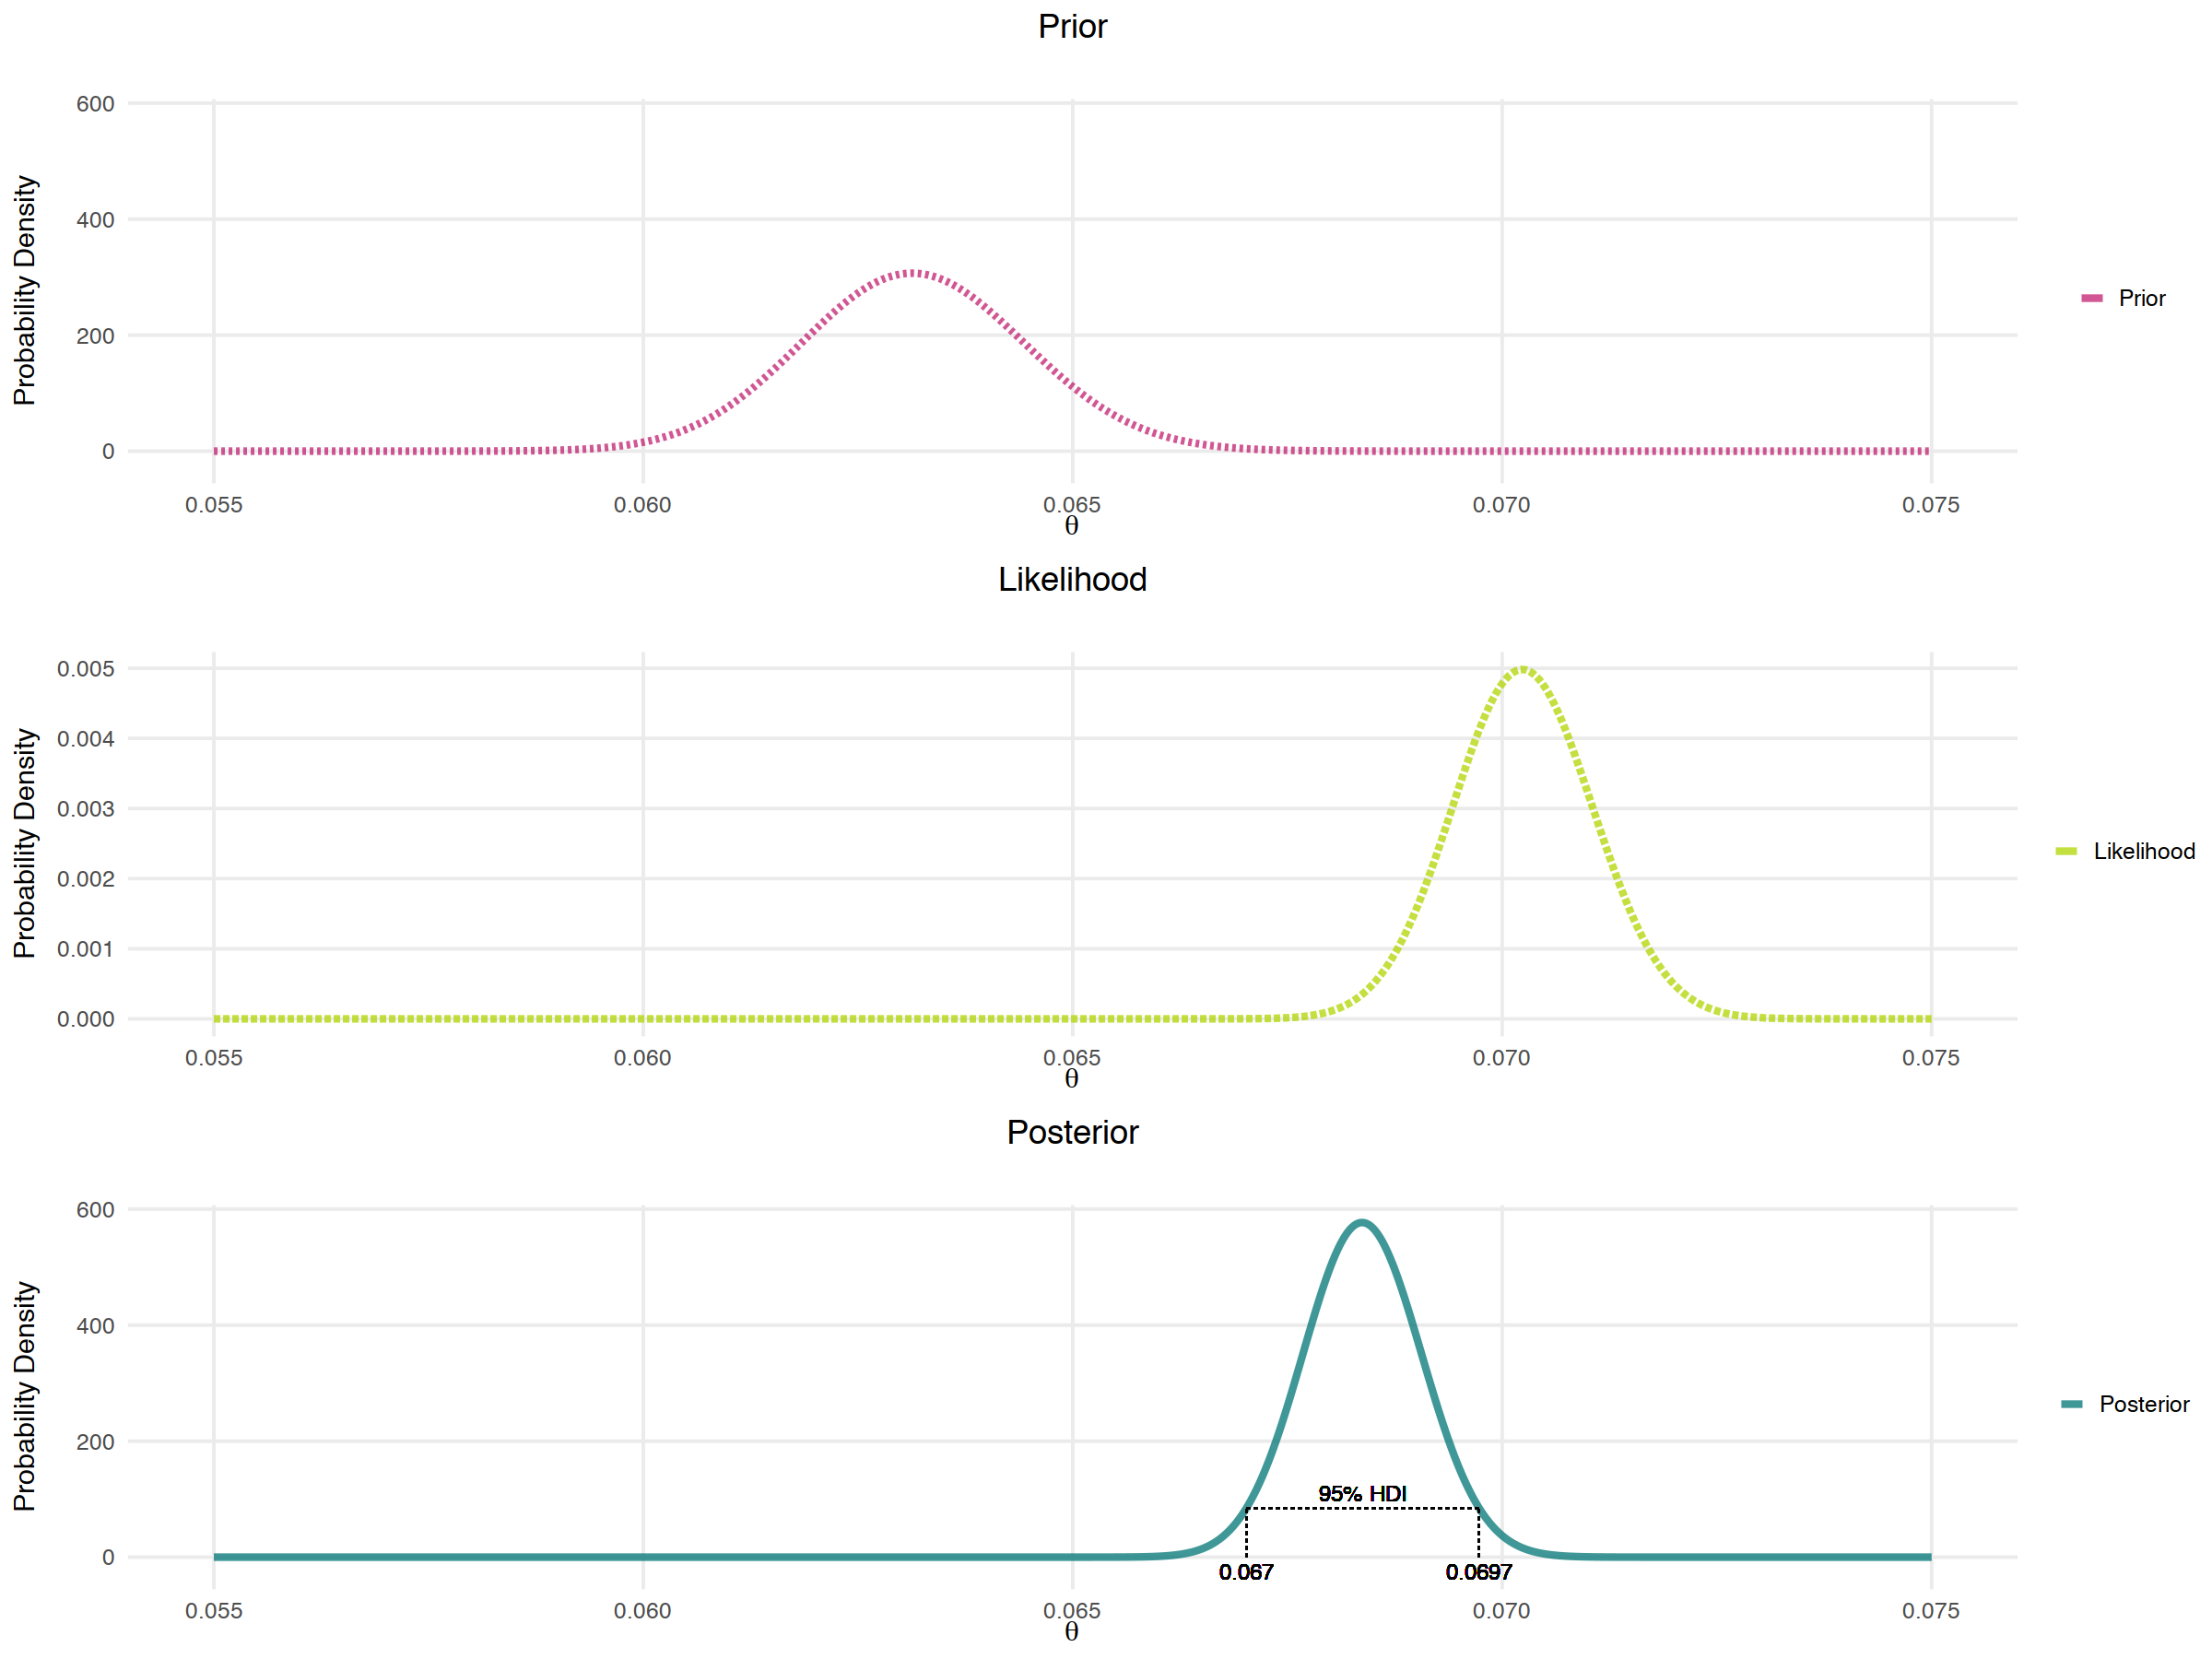

In [9]:
# Initialize helper objects
plots <- list()
labels <- c("Prior", "Likelihood", "Posterior")
linetypes <- c("dashed","longdash","solid")
colors <- c("#C21F70","#B0D400","#007575")

# Create plot objects
for (i in 1:length(labels)){
    plots[[i]] <- ggplot(dists[dists$variable == tolower(labels[i]),], aes(x = thetas, y = value, group = variable, colour = variable, linetype = variable)) + 
        geom_line(size = 1.75, alpha = 0.75) +
        xlim(0.055, 0.075) + 
        scale_linetype_manual(values = linetypes[i], guide = F) + 
        scale_color_manual(values = colors[i], name = "", labels = labels[i]) +
        labs(title = labels[i], subtitle = "", x = bquote(theta), y = "Probability Density\n") +
        theme_minimal(base_size = 18) + theme(plot.title = element_text(hjust = 0.5)) +
        theme(legend.title = element_blank()) + theme(panel.grid.minor = element_blank())

    if (i == 3){
        # Mark the 95% HDI in posterior
        hdi_post <- hdi(qbeta, shape1 = alpha_post, shape2 = beta_post, credMass = 0.95)
        hdi_yend <- mean(c(dbeta(hdi_post[1], alpha_post, beta_post), dbeta(hdi_post[2], alpha_post, beta_post)))
        plots[[i]] <-  plots[[i]] +
            geom_segment(aes(x = hdi_post[1], y = 0.0, xend = hdi_post[1], yend = hdi_yend), linetype = "dashed", colour = 'black') +
            geom_segment(aes(x = hdi_post[2], y = 0.0, xend = hdi_post[2], yend = hdi_yend), linetype = "dashed", colour = 'black') + 
            geom_segment(aes(x = hdi_post[1], y = hdi_yend, xend = hdi_post[2], yend = hdi_yend), linetype = "dashed", colour = 'black') + 
            geom_text(aes(label = '95% HDI', x =  (hdi_post[1] + hdi_post[2]) / 2, y = hdi_yend*1.3), size = 5, colour = 'black') + 
            geom_text(aes(label = paste0(round(hdi_post[1], 4)), x = hdi_post[1], y = -hdi_yend*0.3), size = 5, colour = 'black') + 
            geom_text(aes(label = paste0(round(hdi_post[2], 4)), x = hdi_post[2], y = -hdi_yend*0.3), size = 5, colour = 'black')
        
        ylims <- layer_scales(plots[[i]])$y$range$range
        plots[[1]] <- plots[[1]] + ylim(ylims[1],ylims[2])
    }
}

# Show plots
options(repr.plot.width=20, repr.plot.height=15)
grid.newpage()
grid.draw(rbind(ggplotGrob(plots[[1]]), ggplotGrob(plots[[2]]), ggplotGrob(plots[[3]]), size = "last"))

As can be observed from the three plotted distributions above the __posterior__ is nothing but a __compromise between prior and likelihood__. In our example the prior itself is still much wider than the posterior (contains more uncertainty), but this doesn't have to be the case. In fact, when incorporating strong prior assumptions any new observation may have little influence on the posterior distribution. On the other hand, when the number of new observations is large the prior is rather dominated by the likelihood.

What's interesting about the way how both prior and likelihood inform the posterior distribution is that it might reflect things happening in an online A/B test much more accurately than frequentist statistics can do. Especially when looking at significant changes made to a user's product, once off measured effects may be misleading and may not sufficiently capture long-term behaviour.

Example in one plot ... eventhough likelihood does not follow beta distribution we just use to have everything in plot ...

In [395]:
# Represent all distributions as beta in order to have all in same plot
prior <- dbeta(thetas, alpha, beta)
likelihood <- dbeta(thetas, z+1, N-z+1)
posterior <- dbeta(thetas, alpha_post, beta_post)

# Combine distributions and prepare before plotting
dists <- data.frame(cbind(thetas, prior, likelihood, posterior))
dists <- melt(dists, id.vars = "thetas")

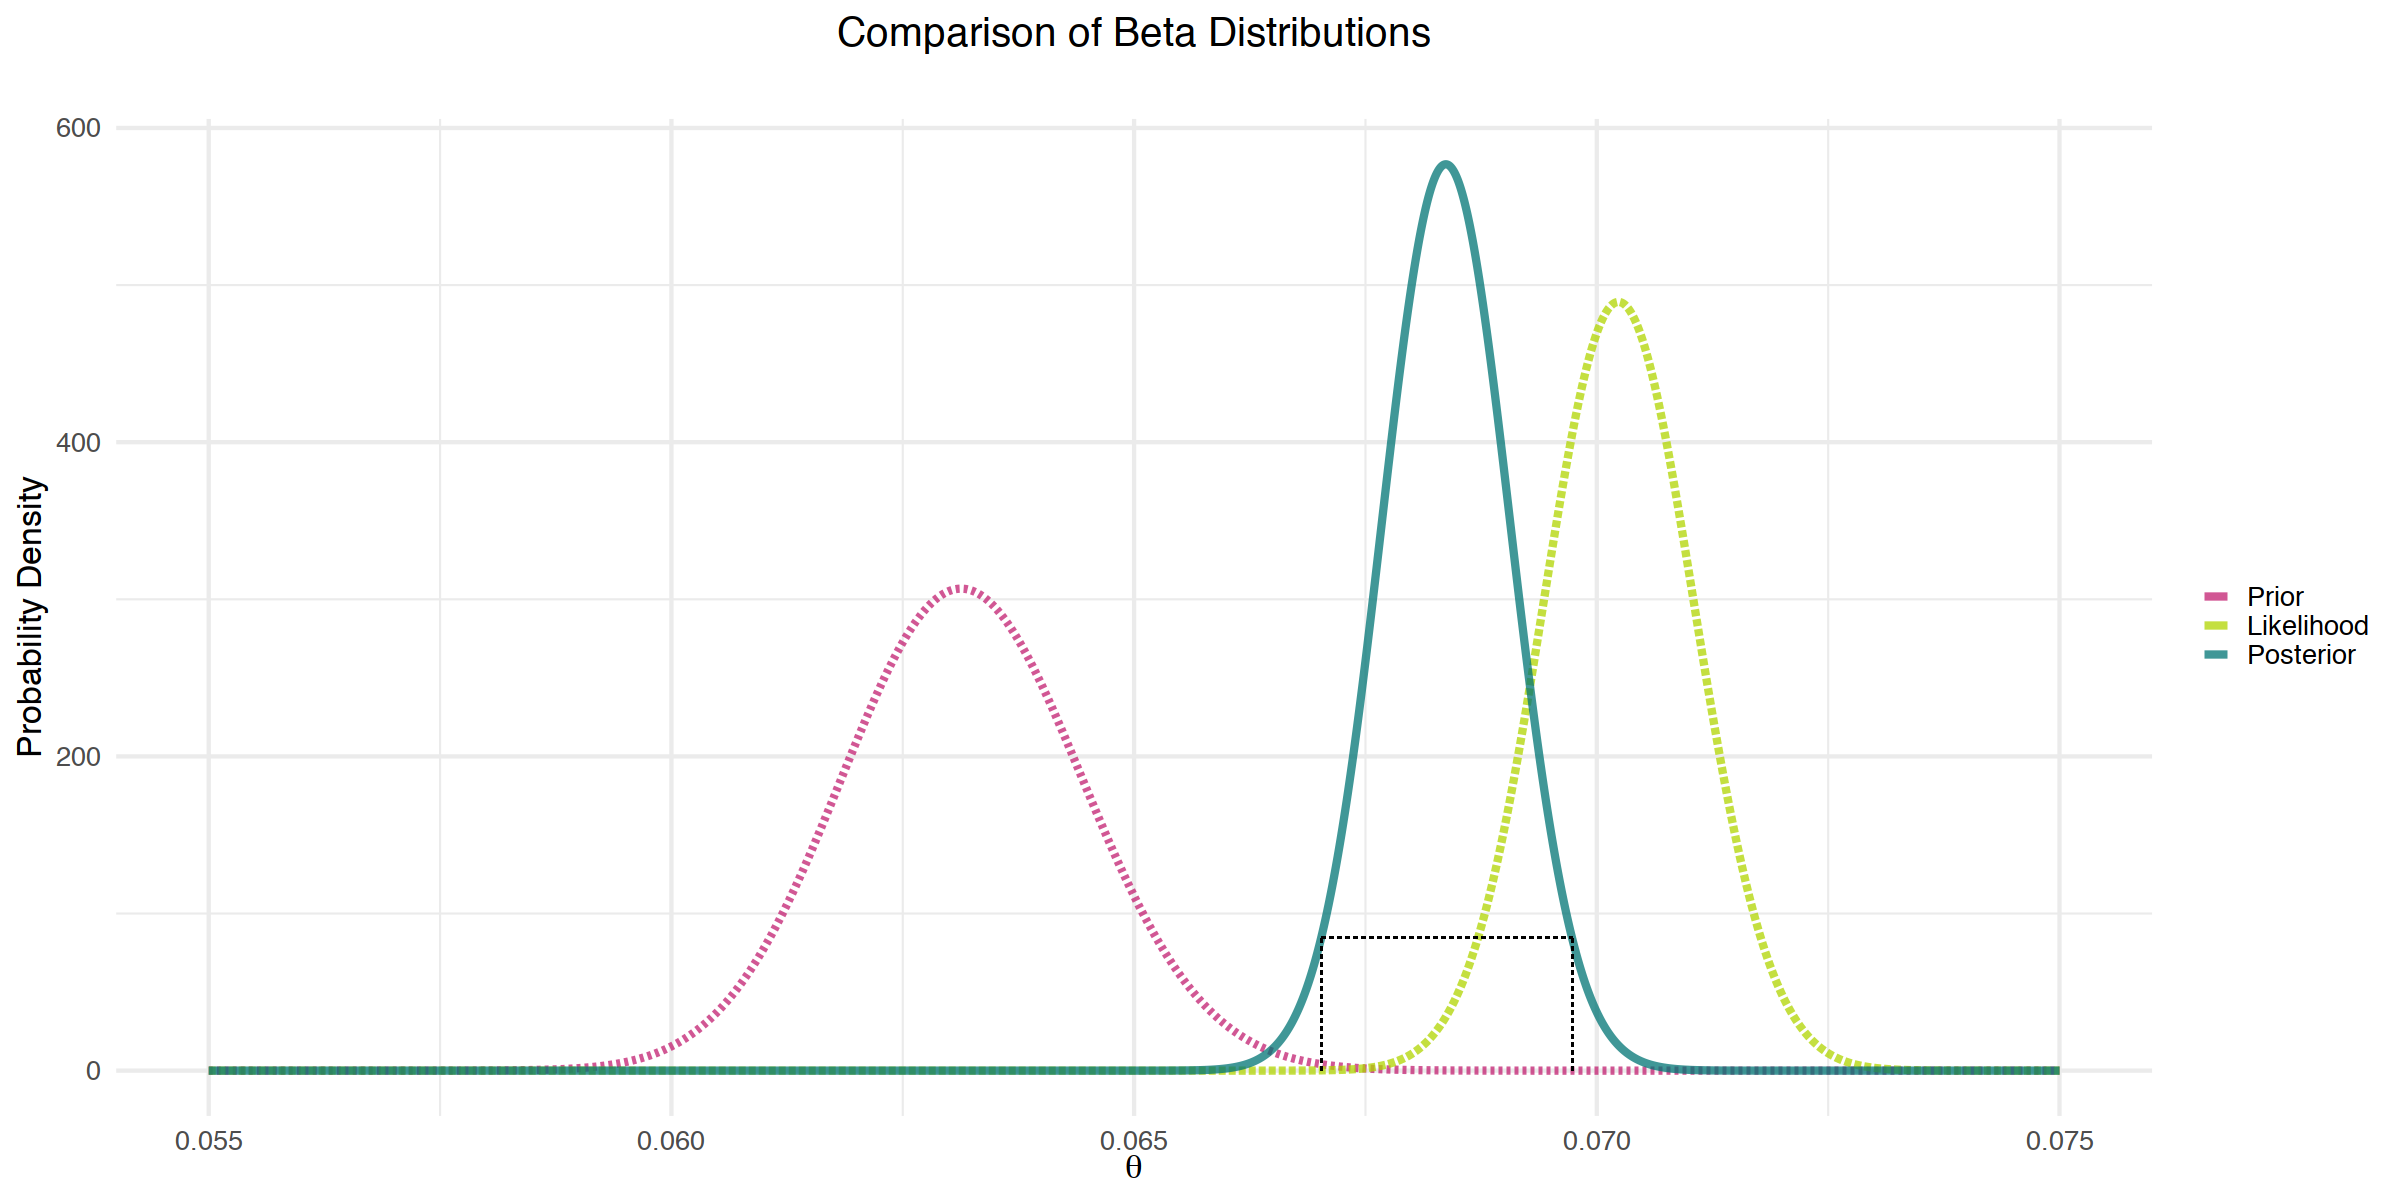

In [396]:
# Finally plot everything
# Change plot size
options(repr.plot.width=20, repr.plot.height=10)

# Plot
labels <- c("Prior", "Likelihood", "Posterior")
ggplot(dists, aes(x = thetas, y = value, group = variable, colour = variable, linetype = variable)) + 
    geom_line(size = 1.75, alpha = 0.75) +
    scale_linetype_manual(values = c("dashed","longdash","solid"), guide = F) + 
    scale_color_manual(values = c("#C21F70","#B0D400","#007575"), name = "", labels = labels) +
    labs(title = "Comparison of Beta Distributions", subtitle = "", x = bquote(theta), y = "Probability Density") +
    geom_segment(aes(x = hdi_post[1], y = 0.0, xend = hdi_post[1], yend = hdi_yend), linetype = "dashed", colour = 'black') +
    geom_segment(aes(x = hdi_post[2], y = 0.0, xend = hdi_post[2], yend = hdi_yend), linetype = "dashed", colour = 'black') + 
    geom_segment(aes(x = hdi_post[1], y = hdi_yend, xend = hdi_post[2], yend = hdi_yend), linetype = "dashed", colour = 'black') +
    theme_minimal(base_size = 20) + theme(plot.title = element_text(hjust = 0.5)) + theme(legend.title = element_blank())

## Bayesian Hypothesis Testing
Up to now we understand how prior and likelihood are used to estimate the posterior distribution of a parameter of interest. We also know how conjugate priors can be used in this context and why they are helpful if we want to estimate the posterior via an analytical solution. However, what's still missing is how a group comparison in a Bayesian framework actually looks like and what things to consider when deciding to reject or accept a hypothesis. While there are other approaches out there we'll take a closer look at two key concepts in the sections below.

### Highest Density Interval (HDI)
A common type of scenario in an experiment is to compare $H0 = 0$ against $H1 \ne 0$. Now, a frequentist on the one hand will reject the null if a confidence interval (e.g. 95% CI) around the estimated parameter does not include 0 - not knowing which values are more likely than others. A Bayesian on the other hand uses the highest density interval (e.g. 95% HDI) of the posterior distribution. The HDI represents the __region of most credible values__ - thus informs us which values are __more likely__ than others. However, we __don't apply the same decision rule__ and simply reject $H0$ if it's not included among the 95% most credible parameter values. Instead, we need an additional concept called __region of practical equivalence__ (ROPE) around $H0$ which we use __in combination with the HDI__. The ROPE consist of all possible value that we consider to be equivalent for practical purposes. This is especially important when the alternative is framed as _non-zero effect_ because with only enough data being collected the null will eventually be rejected - no matter how small an effect may be.

Please note, the HDI describes the range of most credible values, thus must not to be confused with an equally-tailed interval which is defined by lower/upper percentiles of the posterior. While they are the same for symmetric distributions they are fundamentally different when distributions are skewed.

### Region of Practical Equivalence (ROPE)
In addition to the HDI we use a ROPE around the null value in order to decide wether to reject or accept it. The ROPE defines a __narrow interval of values which we consider to be practically equivalent to the null value__ (e.g. zero difference between two groups). In an ideal world the size of the region reflects __the costs and the benefits__ of developing, testing, implementing and maintaining a variation as well as the ability to measure its effect. You should always ask yourself "_How much better does our variation have to  before we consider it a success?_" and "_How much worse do we allow our variation to be before we consider it a failure?_". Defining appropriate boundaries of the ROPE is therefore a case by case decision where narrower limits cause the null to be rejected more often and wider limits will cause the null to be accepted more often. With a ROPE in place we can use the following __decision rules for accepting/rejecting__:
- If the ROPE completely excludes the 95% HDI, we __reject the ROPEd value__ because the 95% most credible values are not considered to be practically equivalent
- If the ROPE completely includes the 95% HDI, we __accept the ROPEd value__ because the 95% most credible values are considered to be practically equivalent
- If the ROPE and 95% HDI only partially overlap, we __remain undecided__ because some of the 95% most credible values are practically equivalent to the ROPEd value and some are not

There are a couple of this to keep in mind, when applying the above decision rules. For example if we decide to reject a ROPEd value we __only reject this particular value__ and not all values within that region. Also, whenever we accept a ROPEd value we only consider the most credible values to be practically equivalent to the null value, but __do not make any statements about its probability__. Finally, when not making a decision we simply acknowledge that so far collected observations are not yet sufficient for making a conclusion. Eventhough the decision rules invite to make compressed statements about the comparison of test and control groups in an A/B test we should __always include a summary of the full posterior distributions__ as well. Reporting parameters such as the mode (most credible value), the mean, the limits of a 95% HDI or information on where the null value (or basically any other value of interest) lies within the posterior are much more informative than simply rejecting/accepting an underlying hypothesis. Especially, in situations where HDI and ROPE partially overlap one can use a much more granular analysis to __agree on completely different decision rules__ than suggested above.

### Comparison of Binomial Distributions
In order to understand how both HDI and ROPE are used in an A/B test we look at a simple example of the __comparison of conversion rates__ i.e. means of two independent Binomial distributions. While we consider the data created above to be the observations of the control, we introduce another set of events which then reflect observations of the variation. Finally, comparing both groups requires to get an accurate __representation of each posterior__ distributions. One way to do this is to __approximate exact values__ by sampling a large number of representative points from the posterior. In our case these are two Beta distributions.

First, we add some __toy data for the test group__. For simplicity, we use the same prior and the corresponding parameters $a$ and $\beta$ as used for the example above.

In [10]:
# Create additional toy data for second samples (prior will be same as for control)
y_test <- c(replicate(6695, 1), replicate(84096-6695, 0)) # used for observations of variation

print(paste0("Sample mean of oberservations used for likelihood of test: ",round(mean(y_test), 5)))

[1] "Sample mean of oberservations used for likelihood of test: 0.07961"


Next, we update the the parameters of the second posterior based on the observations of test group. Finally, we __draw $n$ samples__ from each of the posterior distributions.

In [11]:
# Define inputs to rbeta
samples <- 100000

# Sample from exact marginal posterior distributions
post_control = rbeta(n = samples, shape1 = alpha_post, shape2 = beta_post)
post_test = rbeta(n = samples, shape1 = alpha + sum(y_test == 1), shape2 = beta + sum(y_test == 0))

print(paste0("Posterior means - control: ", round(mean(post_control), 5), " test: ", round(mean(post_test), 5)))

[1] "Posterior means - control: 0.06837 test: 0.07478"


Already by looking at the posterior means i.e. the conversion rates of each group we can observe a clear difference. But is still __difference meaningful__? For his to decide we need to decide what meaningful means to us. We do this by __defining the null value__ and its region of practical equivalence. In addition to this, we can think of another, more ambitious comparison value which may not be used for a final decision, but rather represents a best case result.

In [23]:
# Set comparison value (e.g. H0 = 0)
h0 <- 0 # variation is equal to control

# Define ROPE (e.g. 1% worse/better than null)
rel_width <- 0.01 
half_rope <- mean(post_control) * (1+h0+rel_width) - mean(post_control)
rope <- c(0-half_rope, 0+half_rope)
print(paste0("Lower/upper ROPE: ", round(rope[1], 5), "; ", round(rope[2], 5)))

# Set additional comparison value (e.g. variation is at least 8% better than control)
rel_impr <- 0.08

[1] "Lower/upper ROPE: -0.00068; 0.00068"


Our comparison is based on the __differences of the two posterior distributions__. We compute this in the next step ...

In [24]:
# Parameter summary
diffs <- data.frame(diff = post_test - post_control)
diffs_mean <- mean(diffs$diff)
diffs_hdi <- hdi(diffs$diff)
diffs_density <- density(diffs$diff)
diffs_mode <- diffs_density$x[which.max(diffs_density$y)]

# Print summary
print(paste0("Summary of difference of posteriors:"))
print(paste0("Mean: ", round(diffs_mean, 5)))
print(paste0("Mode: ", round(diffs_mode, 5)))

[1] "Summary of difference of posteriors:"
[1] "Mean: 0.00641"
[1] "Mode: 0.00634"
[1] "95% HDI - lower: 0.00438 upper: 0.00841"


... and then __summarize the results__. These are the hard facts for a decision if we need to decide wether both group means are different from each other.

In [29]:
# Calculate probabilities of true value being in rope
in_rope <- mean(diffs$diff > rope[1] & diffs$diff < rope[2]) * 100

# Calculate probabilities of value being greater/smaller than value
comparison_val <- mean(post_control) * (1+rel_impr) - mean(post_control)
prob_greater <- 100 * round(mean(diffs$diff > comparison_val), 4)
prob_smaller <- 100 - prob_greater
comparison_label <- paste0(prob_smaller,"% < ",round(comparison_val,4)," < ",prob_greater,"%")

# Return summary
print(paste0("H0: Difference between the two groups is equal to ", h0, "."))
print(paste0("Lower/upper ROPE: ", round(rope[1], 5), "; ", round(rope[2], 5)))
print(paste0("Probability of difference of means being in ROPE: ", round(in_rope, 5), "%"))
print(paste0("Difference of means: ", round(diffs_mean, 5)))
print(paste0("Lower/upper 95% HDI: ", round(diffs_hdi[1], 5), "; ", round(diffs_hdi[2], 5)))
print(paste0("Comparison value: ", round(comparison_val, 5)))
print(paste0("Probability of difference of means being smaller/greater than comparison value: ", comparison_label))

[1] "H0: Difference between the two groups is equal to 0."
[1] "Lower/upper ROPE: -0.00068; 0.00068"
[1] "Probability of difference of means being in ROPE: 0%"
[1] "Difference of means: 0.00641"
[1] "Lower/upper 95% HDI: 0.00438; 0.00841"
[1] "Comparison value: 0.00547"
[1] "Probability of difference of means being smaller/greater than comparison value: 17.99% < 0.0055 < 82.01%"


Turning back the the __decision rules__ outlined above, we can reject $H0$ because the 95% HDI completely excludes the ROPE. This means 95% of all values are not considered practically equivalent the null value. Despite that, with 82.01% we see a high probability of the difference between the two groups being greater than the much more ambitious comparison value. Again - and this is important - we can only make such statements because we work in a Bayesian framework. In frequentist hypothesis testing we wouldn't know which value was more or less likely than another.

For sure we can make the summary of the comparison a bit more appealing ...

In [35]:
# Define function for creating histogram of posterior
plot_histogram <- function(data, title, comparison_value = NULL, rope = NULL){

    # Set size of plot
    options(repr.plot.width=20, repr.plot.height=10)
    theme_update(plot.title = element_text(hjust = 0.5))
    
    # Generate additional data
    diffs_mean <- mean(data[,1])
    diffs_hdi <- hdi(data[,1])
    names(data) <- "X"

    # Histogram with density plot
    histogram <- ggplot(data, aes(x=X)) + 
        geom_histogram(aes(y = ..density..), bins = 100, colour = "black", fill = "white") +
        geom_density(alpha = .10, fill = "#007575") + 
        labs(title = title, subtitle = "", x = expression(theta[2]~-~~theta[1]), y = "Frequency") +
        theme_minimal(base_size = 20) + theme(plot.title = element_text(hjust = 0.5))
    
    # Get limits of plot
    ylims <- layer_scales(histogram)$y$range$range
    xlims <- layer_scales(histogram)$x$range$range

    # Add comparison values and labels
    histogram <- histogram + 
        # Marker
        geom_segment(aes(x = diffs_mean, y = 0.0, xend = diffs_mean, yend = ylims[2]*1.1), linetype = "dashed", lwd = 1.25, colour = "#C21F70") + 
        geom_segment(aes(x = diffs_hdi[1], y = 3, xend = diffs_hdi[2], yend = 3), linetype = "solid", lwd = 2, colour = "black") +
        geom_segment(aes(x = diffs_hdi[1], y = 0.0, xend = diffs_hdi[1], yend = ylims[2]), linetype = "dashed", colour = "black") +
        geom_segment(aes(x = diffs_hdi[2], y = 0.0, xend = diffs_hdi[2], yend = ylims[2]), linetype = "dashed", colour = "black") +
        # Labels
        geom_text(aes(label = paste0('Mean = ', round(diffs_mean, 4)), x = diffs_mean, y = ylims[2]*1.13), size = 7, colour = "#C21F70") +
        geom_text(aes(label = '95% HDI', x =  (diffs_hdi[1] + diffs_hdi[2]) / 2, y = -ylims[2]*0.03), size = 7) +
        geom_text(aes(label = paste0(round(diffs_hdi[1], 4)), x = diffs_hdi[1], y = -ylims[2]*0.03), size = 7) +
        geom_text(aes(label = paste0(round(diffs_hdi[2], 4)), x = diffs_hdi[2], y = -ylims[2]*0.03), size = 7)
    
    # Add comparison value from H0 (e.g. H0 = 0)
    if(!is.null(comparison_value)){
        
        # Compare distribution to comparison value
        prob_greater <- 100 * round(mean(data[,1] > comparison_value), 4)
        prob_smaller <- 100 - prob_greater
        comparison_label <- paste0(prob_smaller,"% < ",round(comparison_value, 4)," < ",prob_greater,"%")
        
        # Add to plot
        histogram <- histogram + 
            geom_segment(aes(x = comparison_value, y = 0.0, xend = comparison_value, yend = ylims[2]), linetype = "dashed", lwd = 1.25, colour = "#007575") +
            geom_text(aes(label = comparison_label, x = comparison_value, y = ylims[2]*1.03), size = 7, colour = "#007575")
    }
    
    # Add ROPE
    if(!is.null(rope)){
        
        # Compare distribution to ROPE
        in_rope <- mean(data[,1] > rope[1] & data[,1] < rope[2]) * 100
        rope_label <- paste0(in_rope,"% in ROPE")
        
        # Add to plot
        histogram <- histogram + 
            geom_segment(aes(x = rope[1], y = 0.0, xend = rope[1], yend = ylims[2]*0.9), linetype = "dashed", lwd = 1.25, colour = "#B0D400") +
            geom_segment(aes(x = rope[2], y = 0.0, xend = rope[2], yend = ylims[2]*0.9), linetype = "dashed", lwd = 1.25, colour = "#B0D400") +
            annotate("rect", xmin = rope[1], xmax = rope[2], ymin = 0, ymax = ylims[2]*0.9, fill = "#B0D400", alpha = 0.05) +
            geom_text(aes(label = rope_label, x = mean(rope), y = ylims[2]*0.9*1.03), size = 7, colour = "#B0D400")
    }
        
    return(histogram)
}

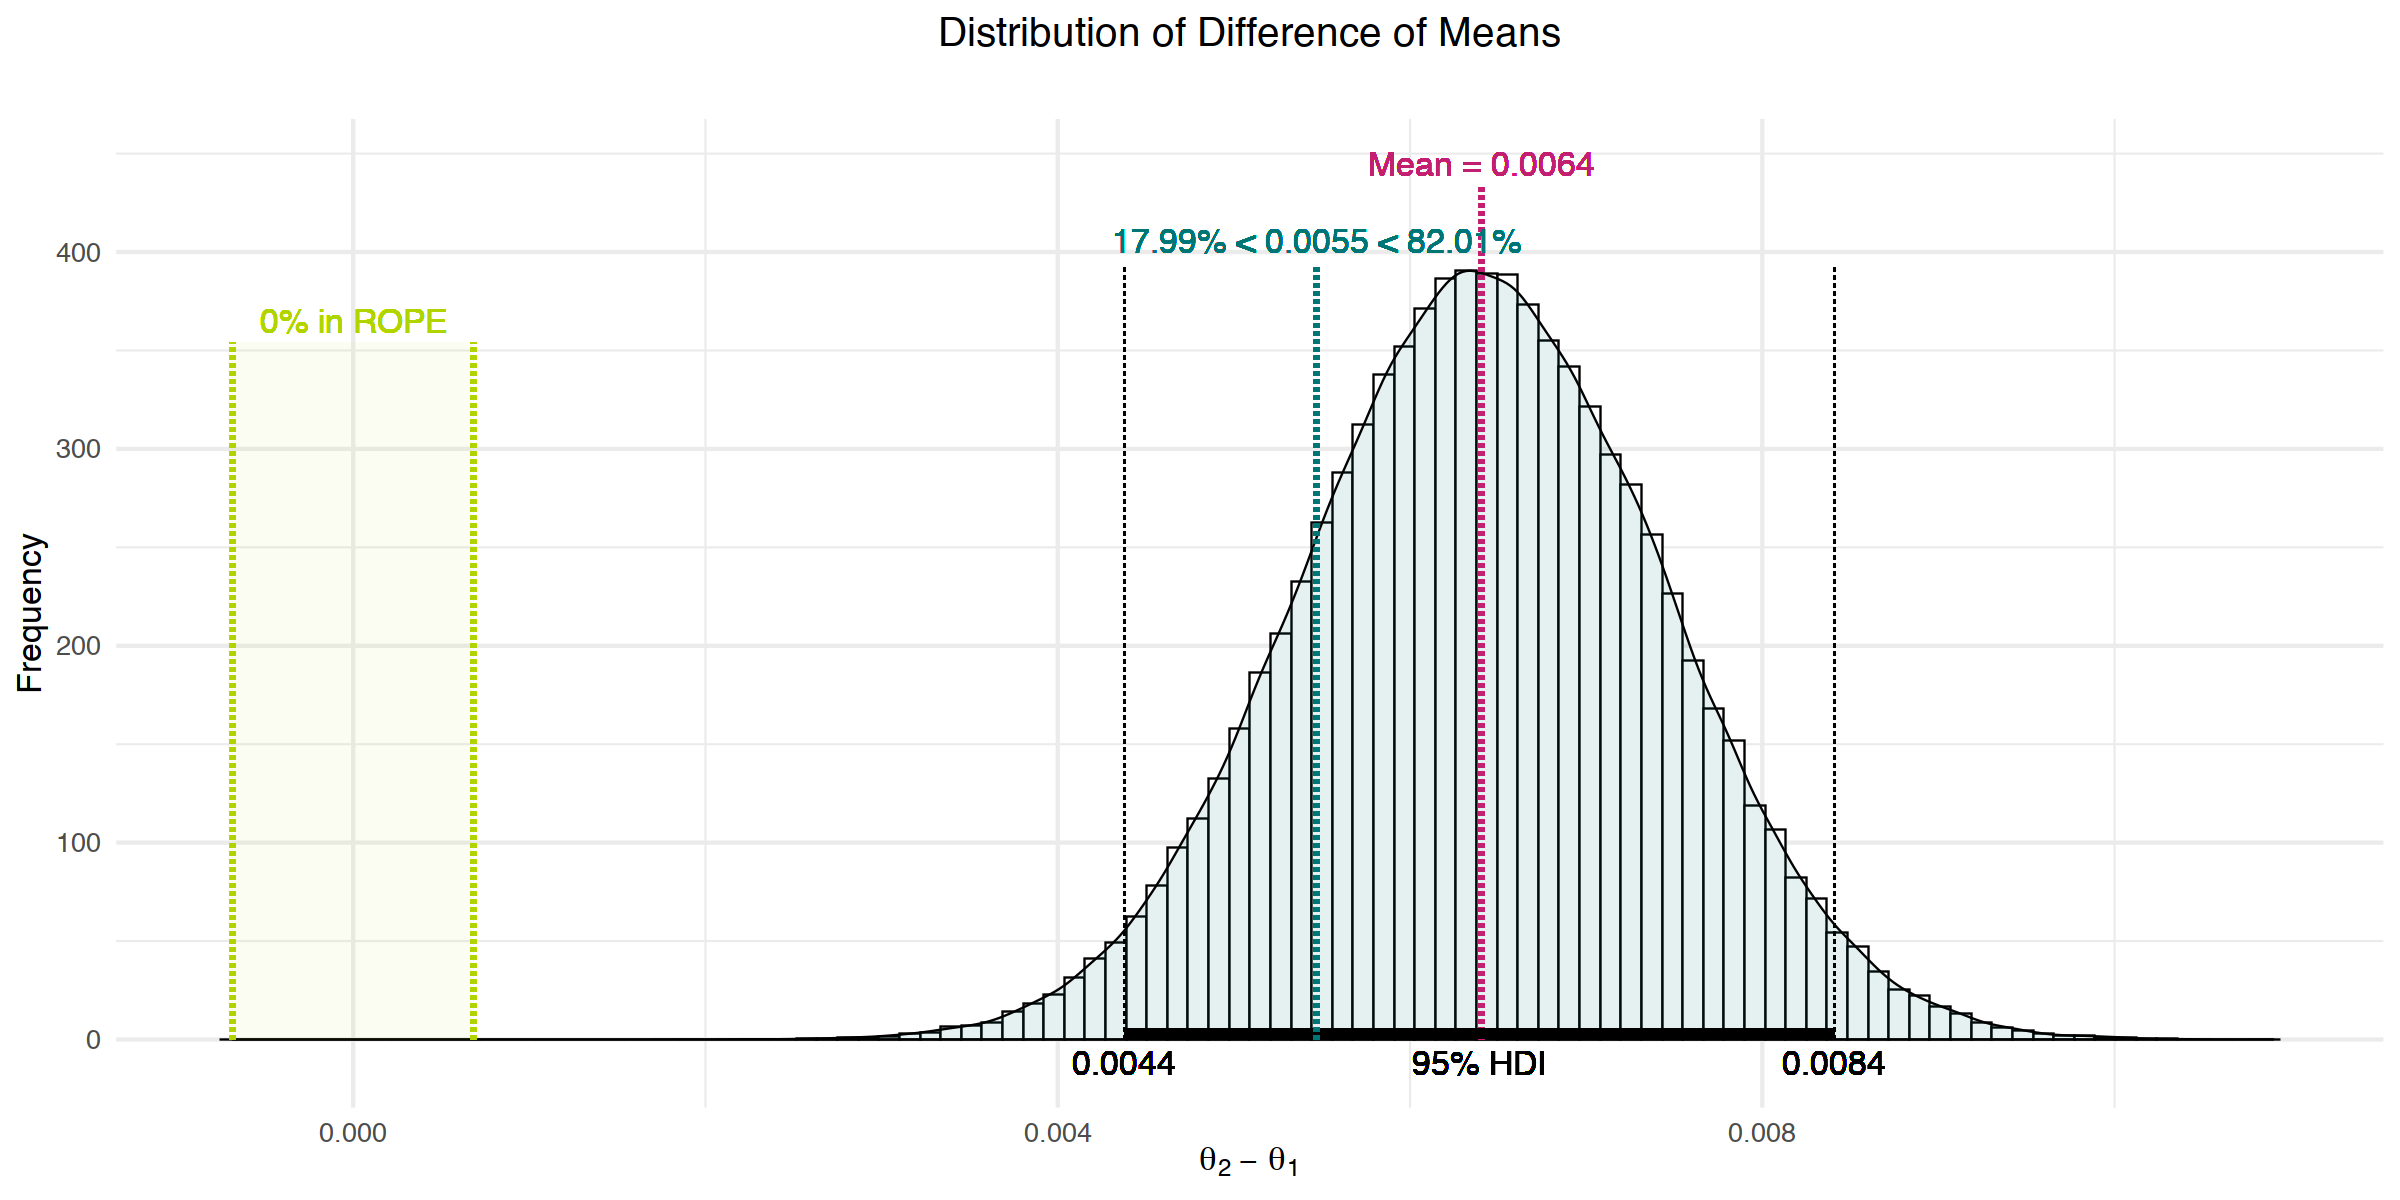

In [36]:
# Plot histogram (may take a while of number of samples is large)
title = "Distribution of Difference of Means"
plot_histogram(diffs, title = title, comparison_value = comparison_val, rope = rope)

In this section we've seen how we can use __Bayesian inference in the context of hypothesis testing__. Because our example included two Binomial likelihoods which have a conjugate prior distribution we were able to sample a large number of estimates from each marginal posterior directly. By applying both concepts, HDI and ROPE, we've used both of the samples to compare the two groups based on the difference of means. Despite making a decision on accepting/rejecting the null hypothesis only, we saw that the full posterior allows for much more granular analysis and even statements about the probability of individual comparison values. Unfortunately, not all likelihoods have conjugate priors and not all posterior distributions have simple forms and low dimensions. And if this is the case we can't use an analytical solution ...

### Markov Chain Monte Carlo (MCMC)
If we cannot sample from the posterior directly or the underlying model is too complex (e.g. large number of unknown parameters) and sampling is difficult, we can use Markov Chain Monte Carlo (MCMC) methods to approximate its exact values - and the more samples we generate, the more accurate is the approximation. While there are many MCMC variants out there we will look at one of them in this notebook more closely: the __Metropolis-Hastings__ algorithm. Starting off from an arbitrary point, the algorithm iteratively __moves across the parameter space__ of the posterior i.e. target distribution with each next move only being dependent on the previous move. As the goal is to find those values of the target distribution which are more likely than others the algorithm tends to accept individual moves only if they lead to higher density regions. By doing so it generates samples which follow the distribution of interest i.e. the target distribution. Before putting this in code and making it more clear and intuitive, we take a look at the __requirements__ of Metropolis-Hastings algorithm. More specifically, the Metropolis-Hastings algorithm with symmetric proposal distribution:
1. Ability to __specify proposal distribution__ to propose a new value $\theta_{prop}$, based on current value $\theta_{curr}$
    - A common choice for the proposal represents the Normal distribution.
2. Ability to __evaluate target distribution__ at any proposed value, to compute $P(\theta_{prop})/P(\theta_{curr})$
    - The target distribution is given by the product of prior and likelihood (which need to be specified) instead of full Bayes formula. That's simply because if we calculate one probability over the other the difficult to compute term $P(D)$ is cancelled out.
3. Ability to generate random value from uniform distribution, to __accept or reject the proposal__
    - More specifically, while moves to values being more likely then the previous one are always accepted, moves to values being less likely are accepted probabilistically only.


The algorithm itself then proceeds as follows:
1. Initialize iterations by choosing arbitrary point in parameter space or target distribution.
2. Repeat until sufficiently representative sample is generated:
    - Propose a new move/value based on current value $\theta_{prop}$~$Normal(\theta_{curr},\sigma)$.
    - Compute probability of moving to proposed value $p_{move} = min(1, P(\theta_{prop})/P(\theta_{curr}))$. In situations where the proposed value is outside the allowed bounds of prior or likelihood $p_{move}$ is set to zero.
    - Accept move if random value $x < p_{move}$ with $x$~$Uniform(0,1), otherwise remain at current position

Before using the Metropolis-Hastings algorithm in an A/B testing example, where we compare two different groups with each other, we __illustrate how the procedure works__ by using a single sample. As we are already familiar with Beta priors and Binomial likelihoods, we do so by building upon the two previous examples. Eventhough we wouldn't use MCMC methods when conjugate priors exist in real life situations. For now, we also don't bother what exactly "sufficiently representative" means, but rather concentrate on understanding how the algorithm works.

In [410]:
# Function for random walk Metropolis-Hastings sampler for single parameter theta
# Source:
# - https://www.casact.org/library/studynotes/MASII_mcmc_algorithms_v0.5.pdf
# - http://www.users.csbsju.edu/~mgass/robert.pdf

metropolis_1d_mcmc <- function(y, alpha = 1, beta = 1, samples = 1000, burnin = 0.1, theta_init = 0.1, sd_init = 0.05, seed=NULL){ 
    
    # Check inputs 
    if (is.null(y)){
        stop('Please provide observations ...')
    }
    z1 <- sum(y == 1)
    N1 <- length(y)
    
    # Define functions
    
    # Define binomial log-likelihood function: P(data|theta)
    log_llh <- function(theta, z=z1, N=N1) {
        # Estimates log-likelihood of binomial distribution
        #
        # Args:
        # - theta: Probability of success, generated at random
        # - data: Vector with data for single sample
        #
        # Returns:
        # - llh: Log-likelihood
        #
        # Notes:
        # The theta values passed into this function are generated at random,
        # and therefore might be inadvertently greater than 1 or less than 0.
        # The likelihood for theta > 1 or for theta < 0 is zero:

        return(dbinom(x = z, size = N, prob = theta, log = T))
        
        # Alternative: Bernoulli log-likelihood
        # return(log(theta^z * (1-theta)^(N-z)))
    }

    # Define beta log-likelihood function
    log_prior <- function(theta, shape1 = alpha, shape2 = beta) {
        # Estimates log-likelihood of prior distribution:
        # Beta distribution as conjugate prior for binomial distribution
        #
        # Args:
        # - theta: Probability of success, generated at random
        # - shape1, shape2: Non-negative parameters of beta distribution
        #
        # Returns:
        # - Log-likelihood of prior

        return(dbeta(theta, shape1 = shape1, shape2 = shape2, log = T))
    }
    
    # Define function for relative probabilities of
    # target distribution / posterior
    log_posterior <- function(theta) {
        # Estimates log-likelihood of prior distribution:
        # Beta distribution as conjugate prior for binomial distribution
        #
        # Args:
        # - theta: Probability of success, generated at random
        # - data: Vector with data for single sample
        # - shape1, shape2: Non-negative parameters of beta distribution
        #
        # Returns:
        # - Log-likelihood of posterior
        return(log_llh(theta) + log_prior(theta))
    }
    
    # Create vector of NAs to store sampled parameters
    chain <- array(dim = c(samples+1,1))
    chain[1,] <- theta_init
    
    # Define burn-in (e.g. drop first 10% of thetas)
    burnin = ceiling(burnin * samples)
    
    # Set seed and run chains
    if(!is.null(seed)){set.seed(seed)}
    
    for (i in 1:samples) {
        
        # Proposed theta centered at current value: If proposed parameter is
        # outside its range keep its current value, otherwise keep the
        # proposed value (current + proposed)
        theta_prop <- rnorm(n = 1, mean = chain[i,], sd = sd_init)
        theta_prop <- ifelse((theta_prop < 0 | theta_prop > 1), chain[i,], theta_prop)
        
        # Calculate probability of accepting new value of theta
        prob_accept <- min(1.0, exp(log_posterior(theta_prop) - log_posterior(chain[i,])))
        
        # Generate a random uniform value from the interval [0,1] to
        # decide whether or not to accept the proposed theta
        chain[i+1,] <- ifelse(runif(1) < prob_accept, theta_prop, chain[i,])
        
    }
    
    # Return trimmed chain without burn-in values
    return(chain[-(1:burnin),])
}

Run chain i.e. sample from posterior ... approximate

In [16]:
# Define remaining inputs
sd_init <- 0.0025

# Run metropolis sampler
chain <- metropolis_1d_mcmc(y_control, alpha = alpha, beta = beta, samples = samples, sd_init = sd_init)

Create summary of chain and plot results ...

In [17]:
# Parameter summary of chain
chain_density <- density(chain)
chain_mode <- chain_density$x[which.max(chain_density$y)]
chain_mean <- mean(chain)
chain_sd <- sd(chain)
chain_hdi <- hdi(chain)

# Compute alpha and beta for beta distribution that has the same mean
# and standard deviation as the sample from the posterior:
# -> These could be used as inouts to prior for the next analyses.
chain_alpha <- chain_mean * ((chain_mean * (1-chain_mean) / chain_sd^2) - 1)
chain_beta <- (1-chain_mean) * ((chain_mean * (1-chain_mean) / chain_sd^2) - 1)

# Store chain in data frame for ggplot histogram
chain_df <- data.frame(chain = chain)

# Print summary of chain
paste0("MCMC summary of posterior:")
paste0("Mean: ", round(chain_mean, 5))
paste0("Mode: ", round(chain_mode, 5))
paste0("95% HDI - lower: ", round(chain_hdi[1], 5), " upper: ", round(chain_hdi[2], 5))

[1] "MCMC summary of posterior:"

[1] "Mean: 0.06837"

[1] "Mode: 0.06845"

[1] "95% HDI - lower: 0.06708 upper: 0.0698"

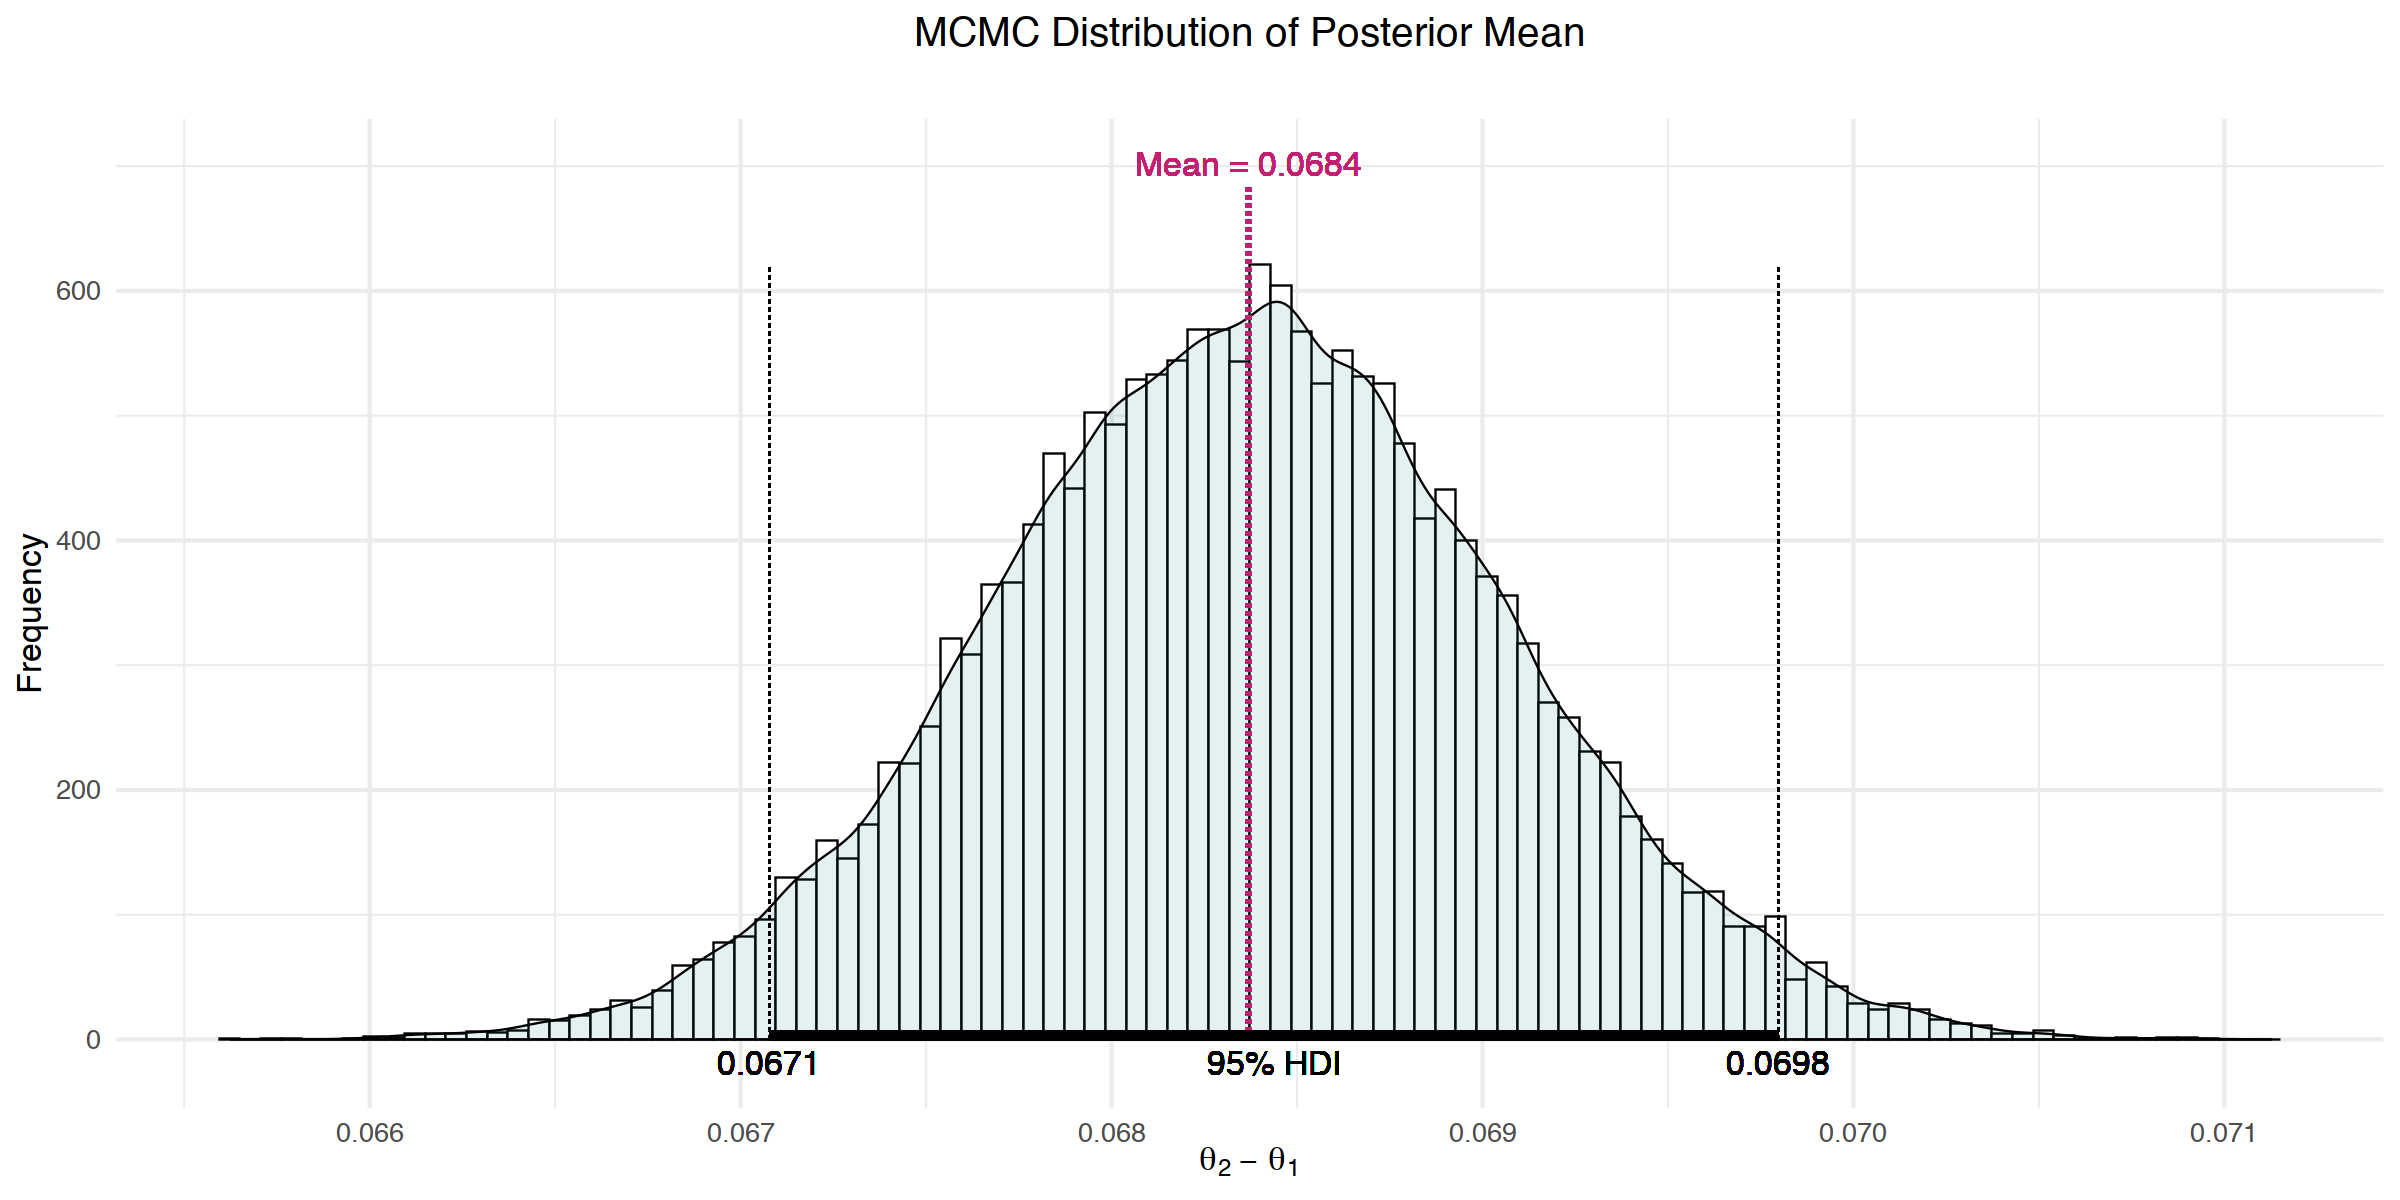

In [18]:
# Plot histogram (this time without comparison value)
title = "MCMC Distribution of Posterior Mean"
plot_histogram(chain_df, title)

#### Note (Put this to the MCMC example further below):
In applications when the Bayesian posterior is approximated with an MCMC sample, it is important to remember the instability of when he HDI limits. Recall the discussion accompanying Figure 7.13, p. 185, which indicated that the standard deviation of a 95% HDI limit for a normal distribution, across repeated runs with an MCMC sample that has an effective sample size (ESS) of 10,000, is roughly 5% of the standard deviation of parameter posterior. Thus, if the MCMC HDI limit is very near the ROPE limit, be cautious in your interpretation because the HDI limit has instability due to MCMC randomness. Analytically derived HDI limits do not suffer this problem, of course.

MCMC for two paramter case ...
- For simplicity in these examples, we will assume that our beliefs about θ1 are independent of our beliefs about θ2. For example, if I have a coin from Canada and a coin from India, my belief about bias in the coin from Canada could be completely separate from my belief about bias in the coin from India. Independence of attributes was discussed in Section 4.4.2, p. 92. Mathematically, independence means that p(θ1, θ2) = p(θ1)p(θ2) for every value of θ1 and θ2, where p(θ1) and p(θ2) are the marginal belief distributions
    - Krusche ED2, p. 163ff.

- assume that draws from the proposal distribution are independent by passing a covariance matrix, cov_mat, that has 0s off the diagonal implying no covariance between
    - https://www.casact.org/library/studynotes/MASII_mcmc_algorithms_v0.5.pdf P.10

Random walk metropolis ...

In [19]:
# Function for random walk Metropolis-Hastings sampler in two dimensions
# Source:
# - https://www.casact.org/library/studynotes/MASII_mcmc_algorithms_v0.5.pdf
# - http://www.r-5.org/files/books/computers/algo-list/statistics/data-mining/John_K_Kruschke-Doing_Bayesian_Data_Analysis-EN.pdf
# - https://github.com/boboppie/kruschke-doing_bayesian_data_analysis/blob/master/1e/BernTwoMetropolis.R

metropolis_2d_mcmc <- function(y1, y2, alpha = c(1,1), beta = c(1,1), samples = 1000, burnin = 0.1, theta_init = c(0.5,0.5), sd_init = NULL, seed = NULL){ 
    
    # Check inputs 
    if (any(is.null(y1),is.null(y2))){
        stop('Please provide observations ...')
    }
    z1 <- sum(y1 == 1)
    N1 <- length(y1)
    z2 <- sum(y2 == 1)
    N2 <- length(y2)

    # Define functions
    
    # Define joint binomial log-likelihood function: P(data|theta)
    log_llh <- function(theta, z=c(z1,z2), N=c(N1,N2)) {
        # Estimates log-likelihood of binomial distribution
        #
        # Args:
        # - theta: Probability of success, generated at random
        # - data: Vector with data for single sample
        #
        # Returns:
        # - llh: Log-likelihood
        #
        # Notes:
        # The theta values passed into this function are generated at random,
        # and therefore might be inadvertently greater than 1 or less than 0.
        # The likelihood for theta > 1 or for theta < 0 is zero:

        return(dbinom(x = z[1], size = N[1], prob = theta[1], log = T) + 
               dbinom(x = z[2], size = N[2], prob = theta[2], log = T))
    }

    # Define joint beta log-likelihood function
    log_prior <- function(theta, shape1 = alpha, shape2 = beta) {
        # Estimates log-likelihood of prior distribution:
        # Beta distribution as conjugate prior for binomial distribution
        #
        # Args:
        # - theta: Probability of success, generated at random
        # - shape1, shape2: Non-negative parameters of beta distribution
        #
        # Returns:
        # - Log-likelihood of prior
        
        return(dbeta(theta[1], shape1 = shape1[1], shape2 = shape2[1], log = T) + 
               dbeta(theta[2], shape1 = shape1[2], shape2 = shape2[2], log = T))
    }
    
    # Define function for relative probabilities of
    # target distribution / posterior
    log_posterior <- function(theta) {
        # Estimates log-likelihood of prior distribution:
        # Beta distribution as conjugate prior for binomial distribution
        #
        # Args:
        # - theta: Probability of success, generated at random
        # - data: Vector with data for single sample
        # - shape1, shape2: Non-negative parameters of beta distribution
        #
        # Returns:
        # - Log-likelihood of posterior
        
        return(log_prior(theta) + log_llh(theta))
    }
    
    # Create vector of NAs to store sampled parameters
    chain <- matrix(NA, nrow = samples+1, ncol = 2)
    chain[1,] <- theta_init
    
    # Define burn-in (e.g. drop first 10% of thetas)
    burnin = ceiling(burnin * samples)
    
    # Keep track of accepts/rejections
    # n_accepted <- 0
    # n_rejected <- 0
    
    # Set seed and run chains
    if(!is.null(seed)){set.seed(seed)}
    
    for (i in 1:samples) {
        
        # Proposed theta centered at current value: If proposed parameter is
        # outside its range keep its current value, otherwise keep the
        # proposed value (current + proposed)
        theta_curr <- chain[i,]
        theta_prop <- mvrnorm(n = 1, mu = theta_curr, Sigma = sd_init)
        
        #  If any of the values in thetas_prop is not in [0, 1.0] then replace their value with
        # the same element in theta_curr, otherwise keep their values
        theta_prop <- mapply(FUN = function(x,y) ifelse((x > 1 | x < 0), y, x), x = theta_prop, y = chain[i,])
                             
        # Calculate joint probability of accepting new value of theta
        prob_accept <- min(1.0, exp(log_posterior(theta_prop) - log_posterior(theta_curr)))
        
        # Generate a random uniform value from the interval [0,1] to
        # decide whether or not to accept the proposed theta
        if(runif(1) < prob_accept){
            chain[i+1,] <- theta_prop
        } else {
            chain[i+1,] <- theta_curr
        }
    }
    
    # Return trimmed chain without burn-in values
    return(chain[-(1:burnin),])
}

Again, define missing inputs .. this time covariance matrix ... independece ... check meaning!

In [20]:
# Define missing inputs
sd1 <- 0.0015
sd2 <- 0.0015
cov_mat <- matrix(c(sd1^2, 0.00, 0.00, sd2^2), nrow = 2, ncol = 2)

# Run metropolis sampler
chain <- metropolis_2d_mcmc(y_control, y_test, alpha = c(alpha,alpha), beta = c(beta,beta), samples = samples, sd_init = cov_mat)

Summary of chain

In [21]:
# Parameter summary of chain
chain_density <- apply(chain, 2, density)
chain_mode <- lapply(chain_density, function(d) d$x[which.max(d$y)])
chain_mean <- apply(chain, 2, mean)
chain_sd <- apply(chain, 2, sd)
chain_hdi <- apply(chain, 2, hdi)

# Compute alpha and beta for beta distribution that has the same mean
# and standard deviation as the sample from the posterior:
# -> These could be used as inouts to prior for the next analyses.
chain_alpha <- chain_mean * ((chain_mean * (1-chain_mean) / chain_sd^2) - 1)
chain_beta <- (1-chain_mean) * ((chain_mean * (1-chain_mean) / chain_sd^2) - 1)
                    
# Store chain in data frame for ggplot histogram
chain_df <- data.frame(chain)
                     
# Print summary of chain
paste0("MCMC summary of posterior:")
paste0("Mean - control: ", round(chain_mean[[1]], 5), " test: ", round(chain_mean[[2]], 5))
paste0("Mode - control: ", round(chain_mode[[1]], 5), " test: ", round(chain_mode[[2]], 5))
paste0("95% HDI control - lower: ", round(chain_hdi[1,1], 5), " upper: ", round(chain_hdi[1,2], 5))
paste0("95% HDI test - lower: ", round(chain_hdi[2,1], 5), " upper: ", round(chain_hdi[2,2], 5))

[1] "MCMC summary of posterior:"

[1] "Mean - control: 0.06838 test: 0.07477"

[1] "Mode - control: 0.06842 test: 0.07478"

[1] "95% HDI control - lower: 0.06702 upper: 0.07332"

[1] "95% HDI test - lower: 0.0697 upper: 0.0763"

Let's make inference and compare distributions ... PLUS PLOT

In [22]:
# Generate summary statistics
diffs <- data.frame(diff = chain[,2] - chain[,1])
diffs_mean <- mean(diffs$diff)
diffs_sd <- sd(diffs$diff) 
diffs_hdi <- hdi(diffs$diff)
diffs_density <- density(diffs$diff)
diffs_mode <- diffs_density$x[which.max(diffs_density$y)]

# Print summary
paste0("Summary of difference of posteriors:")
paste0("Mean: ", round(diffs_mean, 5))
paste0("Mode: ", round(diffs_mode, 5))
paste0("95% HDI - lower: ", round(diffs_hdi[1], 5), " upper: ", round(diffs_hdi[2], 5))

[1] "Summary of difference of posteriors:"

[1] "Mean: 0.00639"

[1] "Mode: 0.00633"

[1] "95% HDI - lower: 0.00441 upper: 0.00842"

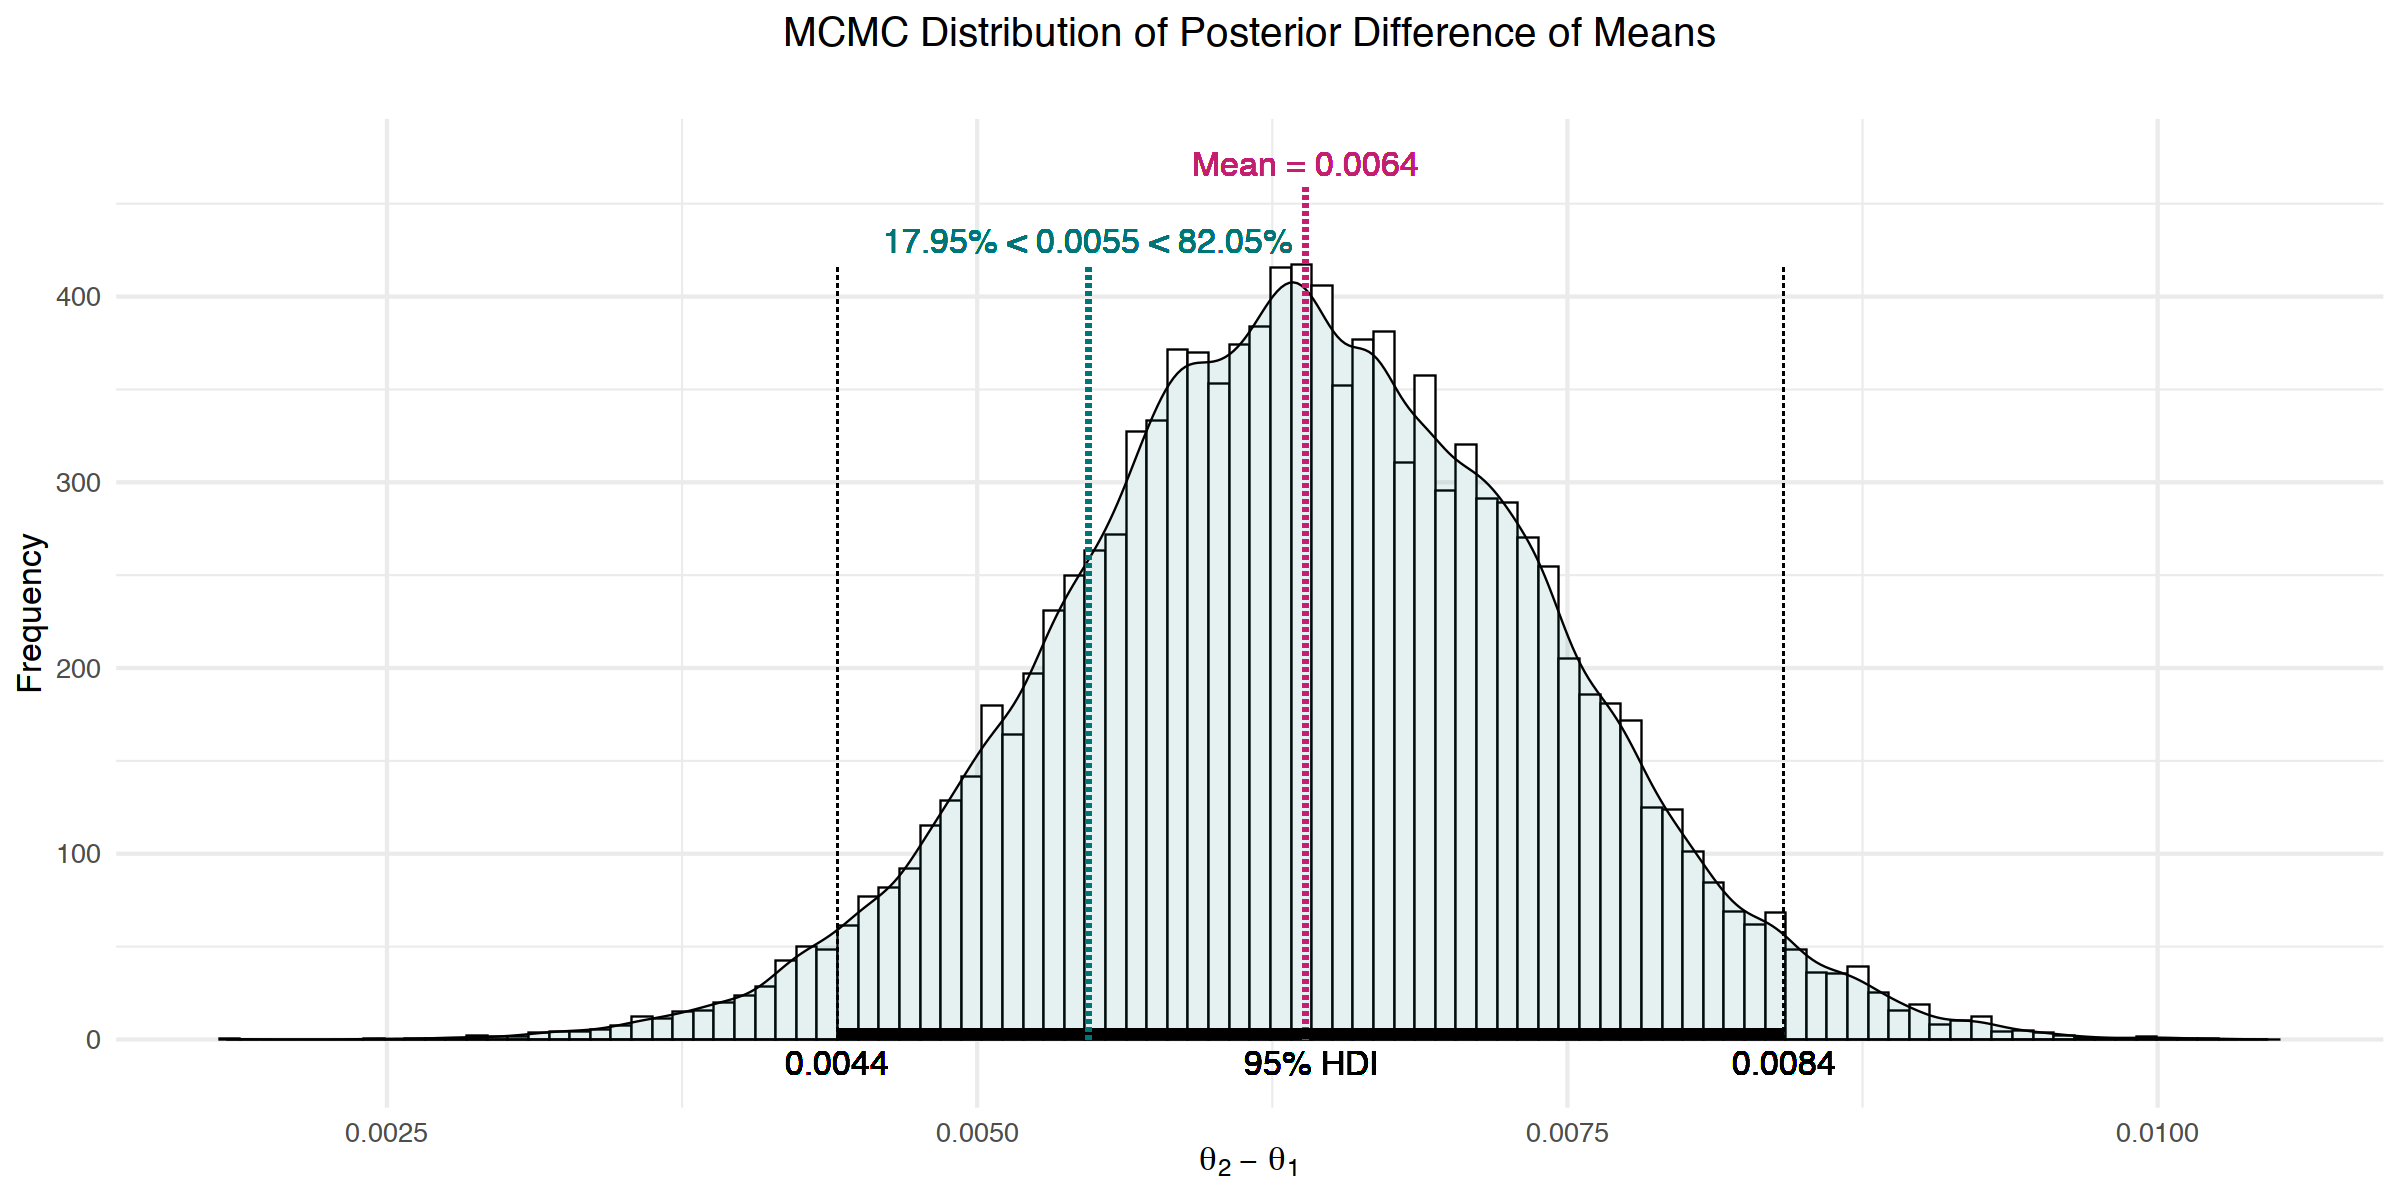

In [23]:
# Define new comparison value based on posterior of control
val <- mean(chain[,1]) * (1+h0) - mean(chain[,1]) 

# Plot histogram
title = "MCMC Distribution of Posterior Difference of Means"
plot_histogram(diffs, title, val)

### How good is our approximation??
- Compare exact and mcmcm distributions ...

In [25]:
# Number of samples to draw from the exact marginal posterior
# distributions (equal to the length of our chain post burnin)
n <- nrow(chain)

# Random samples from marginal distributions
theta_1_exact <- rbeta(n = n, shape1 = alpha + sum(y_control == 1), shape2 = beta + sum(y_control == 0))
theta_2_exact <- rbeta(n = n, shape1 = alpha + sum(y_test == 1), shape2 = beta + sum(y_test == 0))

# Posteriro from MCMC 
theta_1_apprx <- chain[ ,1]
theta_2_apprx <- chain[ ,2]

# Add to matrix
thetas <- cbind(theta_1_exact, theta_1_apprx, theta_2_exact, theta_2_apprx)

# Compare quantiles
quantiles <- apply(thetas, 2, FUN = quantile, c(0.025, 0.05, 0.25, 0.5 ,0.75, 0.95, 0.975))
quantiles

,theta_1_exact,theta_1_apprx,theta_2_exact,theta_2_apprx
2.5%,0.06703457,0.06703933,0.07329059,0.07328003
5%,0.06724641,0.06724424,0.07353038,0.07352029
25%,0.06790786,0.06792269,0.07426058,0.07425048
50%,0.06837349,0.06837530,0.07477175,0.07476426
75%,0.06884233,0.06883004,0.07528190,0.07528641
95%,0.06951449,0.06949419,0.07603396,0.07602506
97.5%,0.06973597,0.06972012,0.07627262,0.07626925


Chain diagnostics ... 
- acceptance rate
- trace plots
- gelman-rubin diagnostic

Source: https://www.casact.org/library/studynotes/MASII_mcmc_algorithms_v0.5.pdf

Tips for optimization: http://www.life.illinois.edu/dietze/Lectures2012/Lesson12_Metropolis.pdf

### Trace Plots

As stated earlier, the goal of MCMC is to gather a representation of the true but incalculable posterior distribution via simulation. But simulations and the code we use to program them can go awry. Even if the simulation is executed flawlessly, we may not have given the simulation program reasonable defaults or let it run long enough to achieve good representation. Therefore, it would behoove us to utilize a set of diagnostics that indicate if the simulation process is behaving as expected. The diagnostics hopefully give us confidence that our samples are converging to a reasonable representation of the target posterior. There are several methods which are necessary but not sufficient to ensure representativeness. We will explore some of them in turn below.
Trace plots - Trace plots involve simulating two or more chains of parameter values and plotting the values of each chain against the sample number of the sampling process, typically on the same set of axes. If the chains are all representative of the posterior distribution, they should overlap each other and be unrelated to their randomly set starting positions. They should also be stationary around the same modal value. We can create trace plots fairly easily with our one-dimensional metropolis_algorithm function used to sample θ. We will run three different chains with 10,000 samples each, and we will start with a diffuse set of theta_seed’s to ensure that the chains mix well despite their initial dispersion.

- Trim
- Explain mixing

In [85]:
# Re-run chain with different initializations and without burnin period
# in order to observe convergence

# Define inputs
samples <- 10000
theta_init <- c(0.01, 0.025, 0.05, 0.075, 0.10, 0.15)
sd_init <- 0.0025

# Create data frame to store chains
chains <- data.frame(matrix(NA, nrow = samples, ncol = length(theta_init)))
names(chains) <- as.character(theta_init)
chains$step <- seq(1, nrow(chains), 1)

# Run chains
for (i in 1:length(theta_init)){
    chains[,i] <- metropolis_1d_mcmc(
        y_control,
        alpha = alpha, beta = beta,
        samples = samples,
        theta_init = theta_init[i], sd_init = sd_init,
        burnin = 0.0)
}

head(chains)

,0.01,0.025,0.05,0.075,0.1,0.15,step
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0.01144578,0.02500000,0.05000000,0.07500000,0.10000000,0.1500000,1
2,0.01215262,0.02500000,0.05380132,0.07437490,0.10000000,0.1500000,2
3,0.01215262,0.02500000,0.05380132,0.07344421,0.10000549,0.1500000,3
4,0.01215262,0.02500000,0.05380132,0.06927231,0.10000549,0.1500000,4
5,0.01215262,0.02631954,0.05380132,0.06927231,0.10000549,0.1497938,5
6,0.01382659,0.03115824,0.05380132,0.06782179,0.09874952,0.1476688,6


In [86]:
melted_chains <- melt(chains, id.vars = "step")
head(melted_chains)

,step,variable,value
,<dbl>,<fct>,<dbl>
1,1,0.01,0.01144578
2,2,0.01,0.01215262
3,3,0.01,0.01215262
4,4,0.01,0.01215262
5,5,0.01,0.01215262
6,6,0.01,0.01382659


Create plots ... start and end of chain

In [204]:
# Change plot size
options(repr.plot.width=24, repr.plot.height=8)

# Plot
trace_plot_start <- ggplot(melted_chains[melted_chains$step <= 200, ], aes(x = step, y = value, group = variable, colour = variable, linetype = variable)) + 
    geom_line(size = 1., alpha = 0.75) +
    scale_linetype_manual(values = rep("solid", length(theta_init)), guide = F) +
    scale_color_manual(values = c("#B0D400", "#007575", "#C21F70", "#577080", "#FFA000", "#333333"), name = "Initial Theta") +
    labs(title = "MCMC Trace Plots Before Convergence", subtitle = "", x = "Step", y = bquote(theta)) +
    theme_minimal(base_size = 20) + theme(plot.title = element_text(hjust = 0.5))

In [205]:
# Trace plot past convergence
trace_plot_end <- ggplot(melted_chains[melted_chains$step > 200, ], aes(x = step, y = value, group = variable, colour = variable, linetype = variable)) + 
    geom_line(size = 1., alpha = 0.75) +
    ylim(0.06, 0.08) + 
    scale_linetype_manual(values = rep("solid", length(theta_init)), guide = F) +
    scale_color_manual(values = c("#B0D400", "#007575", "#C21F70", "#577080", "#FFA000", "#333333"), name = "Initial Theta") +
    labs(title = "MCMC Trace Plots After Convergence", subtitle = "", x = "Step", y = bquote(theta)) +
    theme_minimal(base_size = 20) + theme(plot.title = element_text(hjust = 0.5))

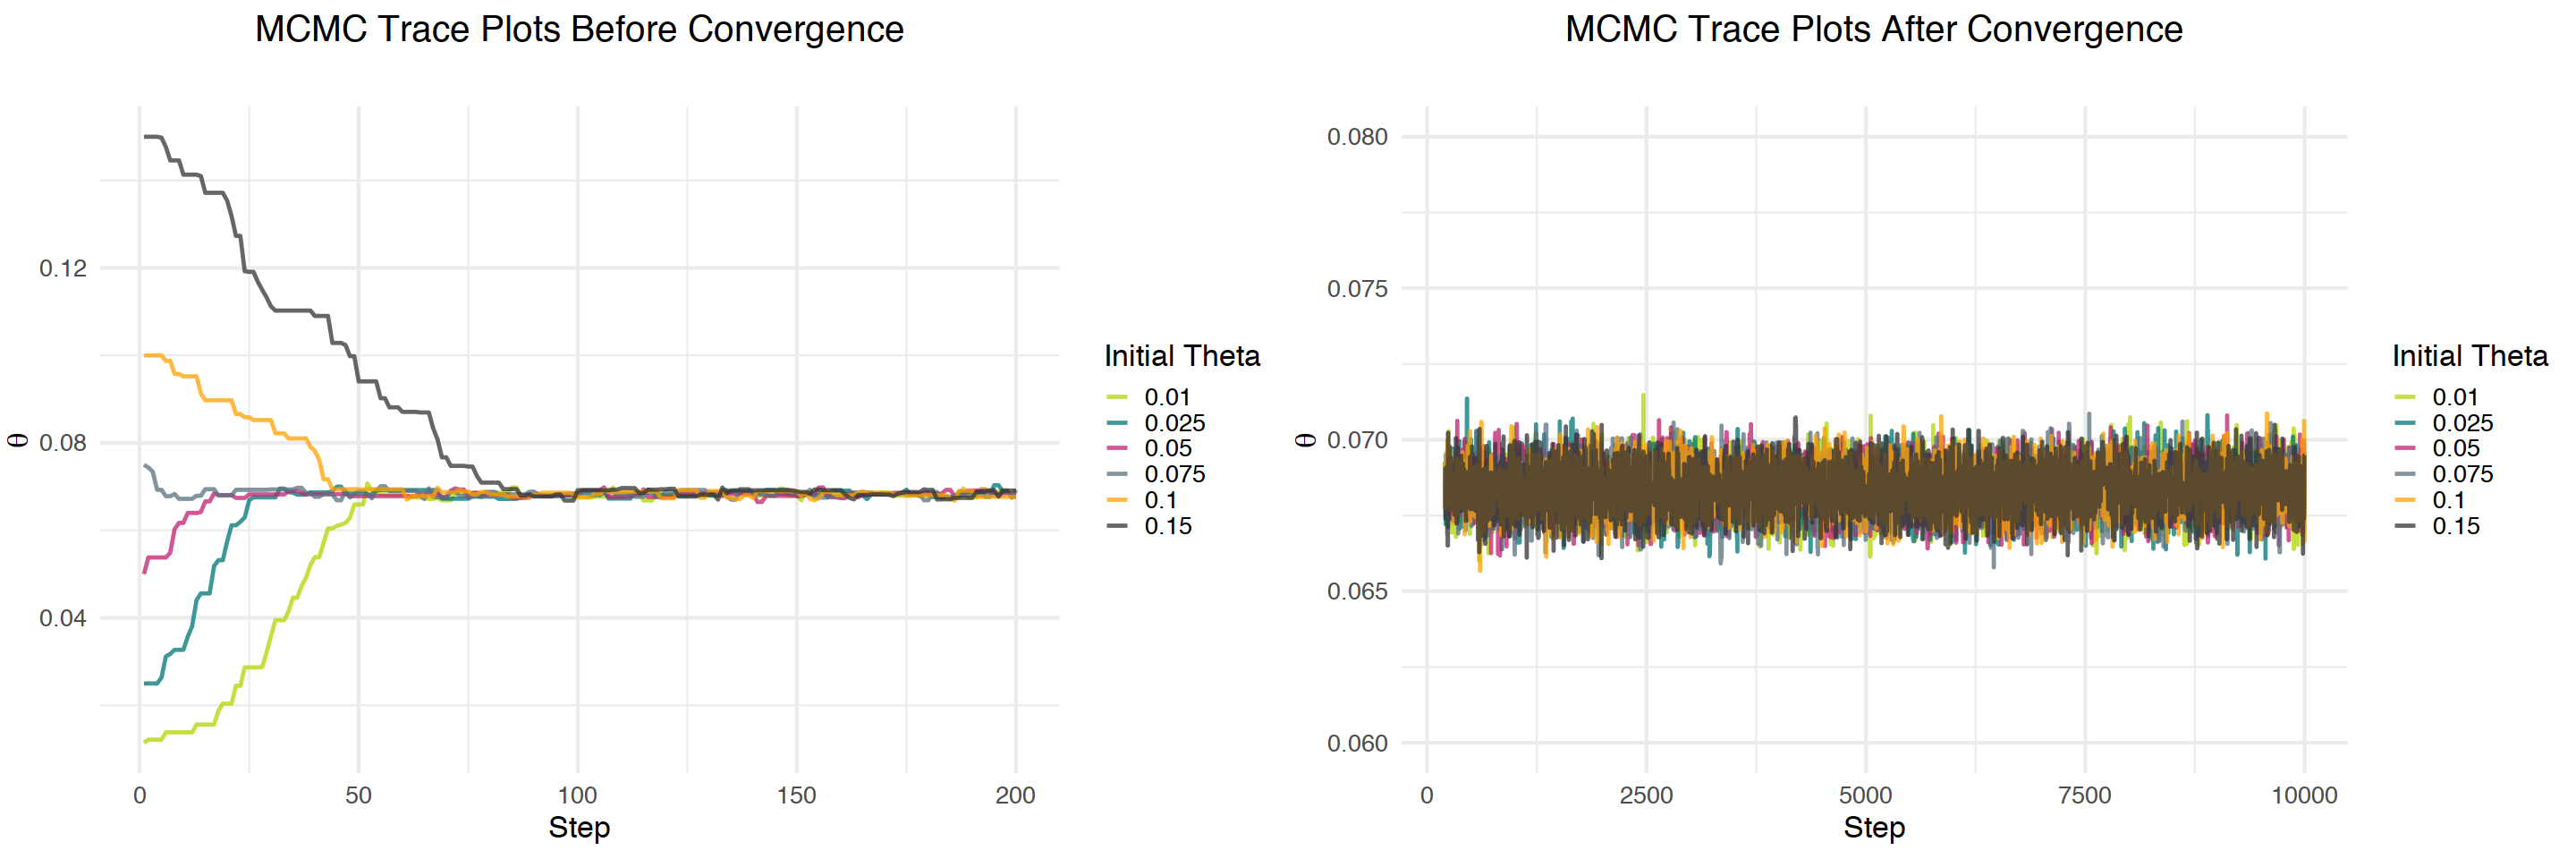

In [207]:
# Show both plots
grid.arrange(trace_plot_start, trace_plot_end, nrow = 1)

### Potential Scale Reduction Factor (PSRF)

- Another source for gelma-rubin: http://www.stat.columbia.edu/~gelman/research/unpublished/1903.08008.pdf
- and another: https://www.rdocumentation.org/packages/coda/versions/0.19-3/topics/gelman.diag
- Method below without correction for sampling variability in variance estimates. But described here: http://www.stat.columbia.edu/~gelman/research/published/brooksgelman2.pdf

In [268]:
# Function for potential scale reduction factor (Gelman & Rubin, 1992; Gelman et al. (2013))
split_Rhat <- function(chains){
    # Split chains in half
    split_half <- function(chain){split(chain, f = seq_along(chain) <= length(chain)/2)}
    splitted_chains <- unlist(apply(chains, 2, split_half), recursive = FALSE)
        
    # Compute within-chain variance
    W <- mean(sapply(splitted_chains, var))
    
    # Compute between-chain variance B and marginal posterior variance V
    n_samples <- length(splitted_chains[[1]])
    n_chains <- 
    B <- var(sapply(splitted_chains, mean))
    V <- (n-1)/n * W + B
    
    # Compite split-Rhat
    Rhat <- sqrt(V / W)
    
    return(Rhat)
}

In [269]:
# Calculate split-Rhat for chains past burnin
burnin = ceiling(0.1 * nrow(chains))
keep_chains <- chains[-(1:burnin),1:6]

split_Rhat(keep_chains)

[1] 1.000737

Additionally we can do this by looking at the metric after 1 to n samples ... ideally the values will converge towards 1 ... if convergence there, but value still high .. run chain longer

In [270]:
# Create a sequence of terminal number of samples. We will compute Gelman-Rubin # after 10 samples, 60 samples, 110 samples,...,total_n samples
n <- nrow(keep_chains)
steps <- seq(from = 100, to = n, by = 100)

# Create vector of 0's to store results
Rhats <- rep(0, length(steps))

# Loop through each terminal_n by truncating the chains at the value
# of n and then calling # the compute_Rhat function. Store the results
# in the Rhats vector that we initialized above
i <- 1
for (n in steps){
    trim_chain <- function(chain, n){return(chain[1:n])}
    trimmed_chains <- apply(keep_chains, 2, trim_chain, n)
    Rhats[i] <- split_Rhat(trimmed_chains)
    i <- i + 1
}

# Store in data frame for plot
Rhats <- data.frame(steps = steps, rhat = Rhats)

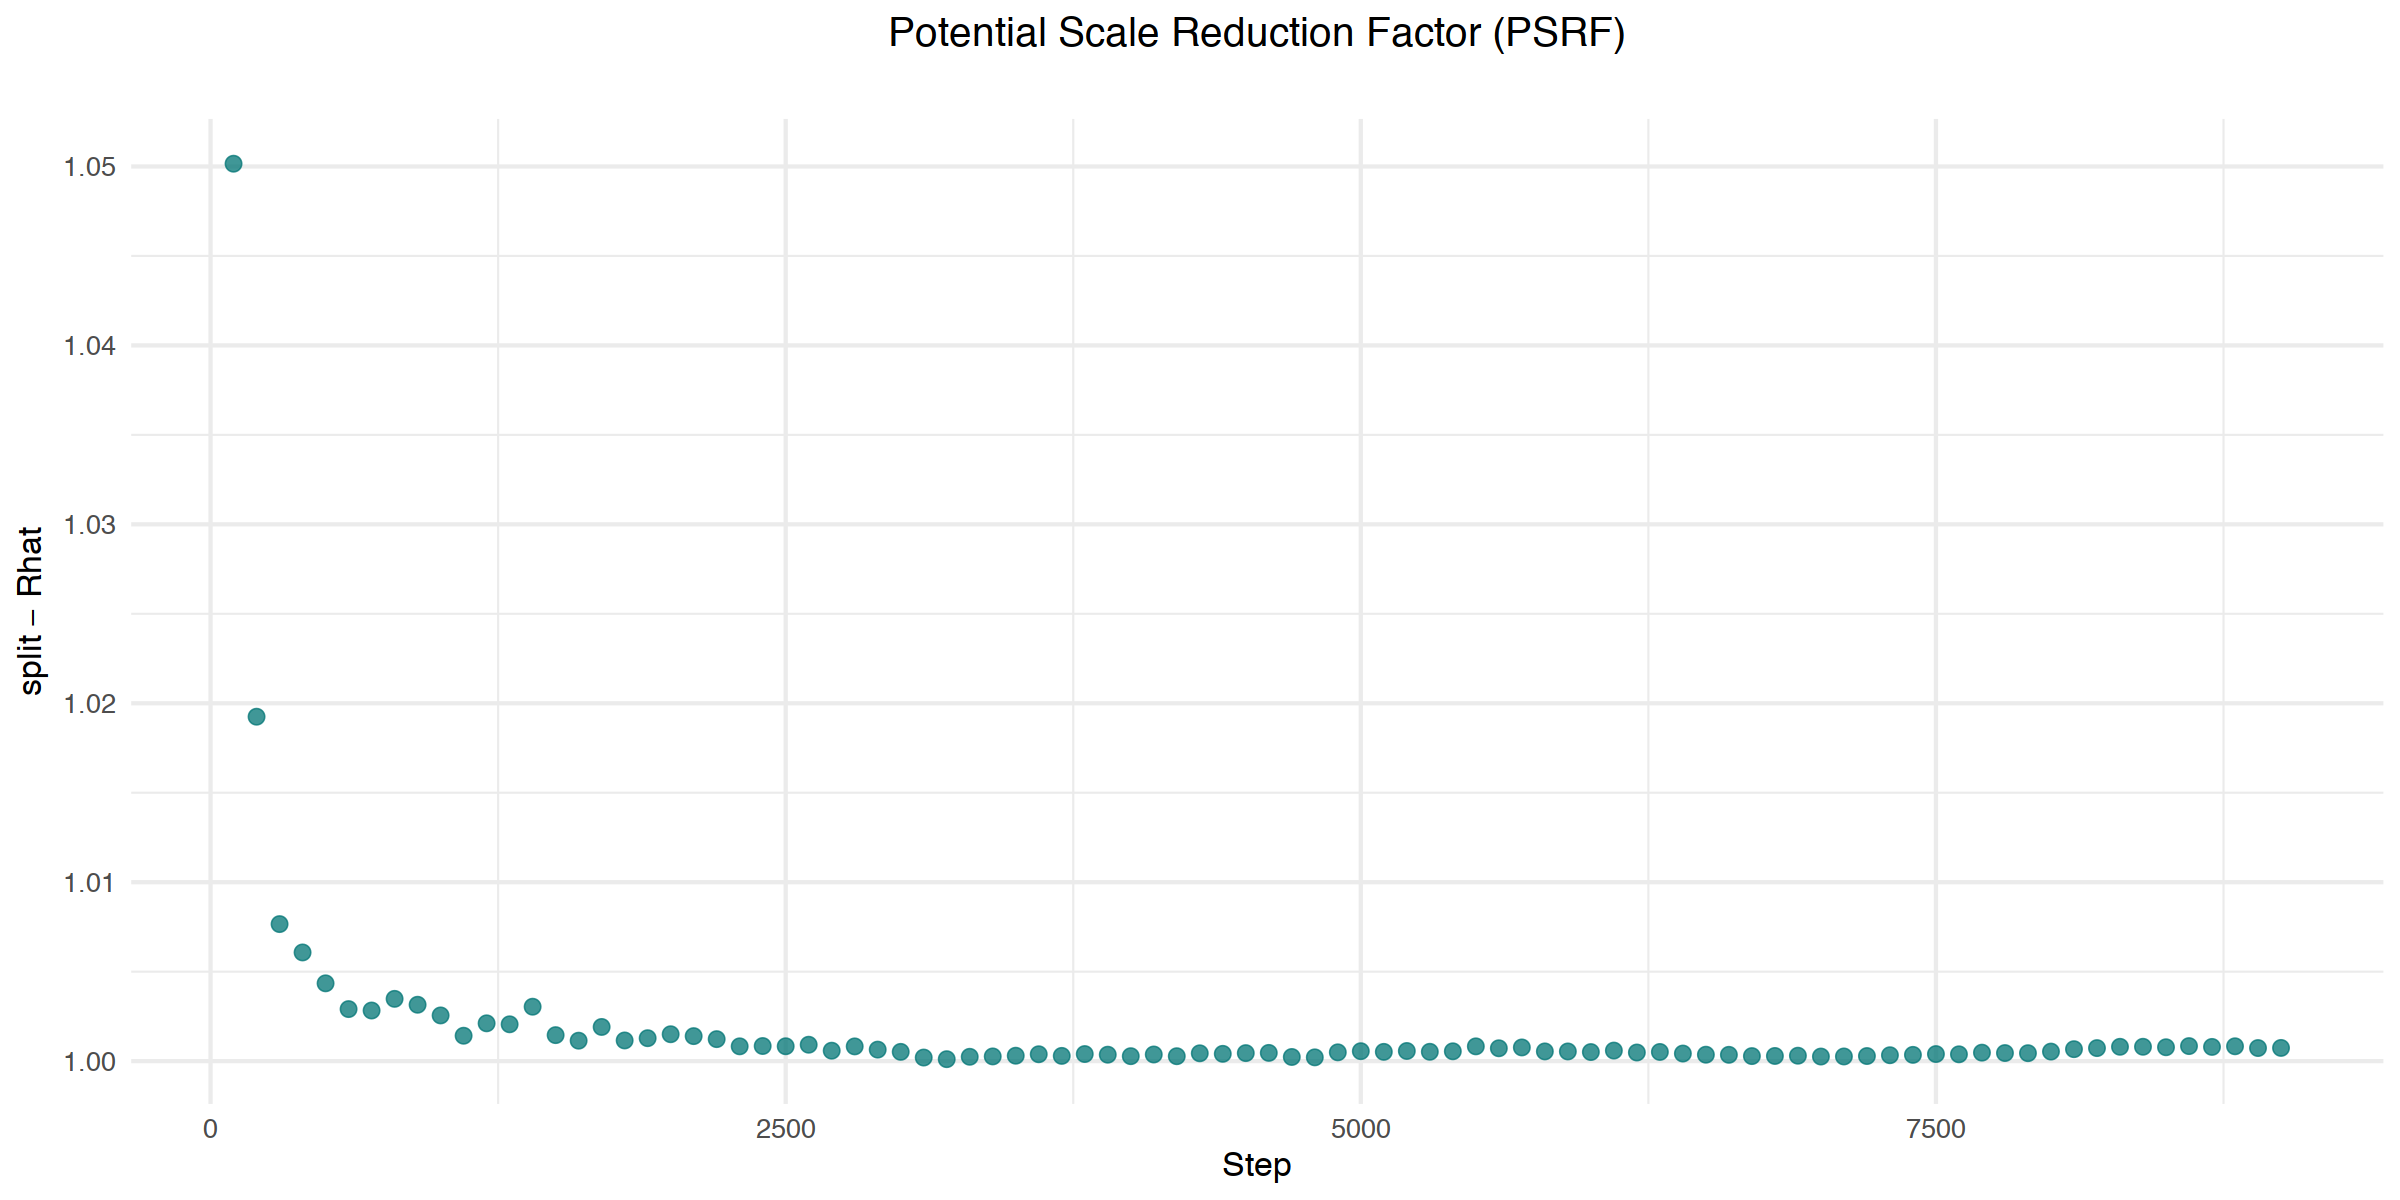

In [271]:
# PSRF plot
options(repr.plot.width=20, repr.plot.height=10)
ggplot(Rhats, aes(x = steps, y = rhat)) + 
    geom_point(size = 4., alpha = 0.75, color = "#007575") +
    labs(title = "Potential Scale Reduction Factor (PSRF)", subtitle = "", x = "Step", y = bquote(split~-~~Rhat)) +
    theme_minimal(base_size = 20) + theme(plot.title = element_text(hjust = 0.5))

### Acceptance Rate
Acceptance Rate - A chain’s acceptance rate can be defined simply as the ratio of the number of unique values in the chain to the total number of samples in the chain. This is equivalent to the percentage of proposed parameter values, θprop, that are accepted in an MCMC sampler. We know that the Gibbs algorithm has an acceptance rate of 1.0 since all draws from the conditional posterior distributions are accepted. As mentioned earlier, sometimes it is impossible to sample from the full conditional posterior so Gibbs’ approximations are employed which will likely not have an acceptance rate of 1.0. Metropolis, Metropolis-Hastings, and HMC algorithms will generally not have acceptance rates approaching 1.0. In most cases it would be counterproductive to have such high acceptance rates for these algorithms since the proposal distribution is only a crude approximation of the target posterior distribution. We can compute the acceptance rates of our three sampled chains for θ. Here’s how we might do it in R.

In [231]:
acceptance <- apply(chains[,1:6], 2, function(chain) 1 - mean(duplicated(chain)))
acceptance

0.01  0.025   0.05  0.075    0.1   0.15 
0.3283 0.3213 0.3203 0.3228 0.3197 0.3277

### Last But Not Least
- BEST package

## References
- [An improved Rhat for assessing convergence of MCMC](http://www.stat.columbia.edu/~gelman/research/unpublished/1903.08008.pdf) 
- [Baby Bayes Using R](http://www2.stat.duke.edu/~rcs46/books/babybayes-master.pdf)
- [Bayesian Assessment of Null Values](http://doingbayesiandataanalysis.blogspot.com/2016/12/bayesian-assessment-of-null-values.html)
- [Bayesian Data Analysis](https://www.academia.edu/32086149/Bayesian_Data_Analysis_Third_Edition_Gelman_.pdf)
- [Bayesian Estimation Supersedes the t Test](http://www.indiana.edu/~kruschke/articles/Kruschke2013JEPG.pdf)
- [Bayesian Parameter Estimation or Bayesian Hypothesis Testing](https://stats.stackexchange.com/questions/246481/bayesian-parameter-estimation-or-bayesian-hypothesis-testing)
- [BEST Vignette](https://cran.r-project.org/web/packages/BEST/vignettes/BEST.pdf)
- [Book Collection](http://hbiostat.org/bib/bayesteach.html)
- [Coda R Documentation](https://www.rdocumentation.org/packages/coda/versions/0.19-3/topics/gelman.diag)
- [Credible Intervals](https://www.sciencedirect.com/topics/mathematics/credible-interval)
- [Doing Bayesian Data Analysis, 1st Edition](http://www.users.csbsju.edu/~mgass/robert.pdf)
- [Doing Bayesian Data Analysis, 2nd Edition](http://www.r-5.org/files/books/computers/algo-list/statistics/data-mining/John_K_Kruschke-Doing_Bayesian_Data_Analysis-EN.pdf)
- [General Methods for Monitoring Convergence of Iterative Simulations](http://www.stat.columbia.edu/~gelman/research/published/brooksgelman2.pdf)
- [Informative and Noninformative Priors](https://statmodeling.stat.columbia.edu/2007/07/18/informative_and/)
- [MCMC Algorithms](https://www.casact.org/library/studynotes/MASII_mcmc_algorithms_v0.5.pdf)
- [Metropolis–Hastings Algorithm](https://en.wikipedia.org/wiki/Metropolis–Hastings_algorithm)
- [My Journey From Frequentist to Bayesian Statistics](https://www.fharrell.com/post/journey/)
- [Stopping Rules and Bayesian Analyis 1](https://statmodeling.stat.columbia.edu/2014/02/13/stopping-rules-bayesian-analysis/)
- [Stopping Rules and Bayesian Analyis 2](https://statmodeling.stat.columbia.edu/2018/01/03/stopping-rules-bayesian-analysis-2/)
- [The Bayesian New Statistics](https://link.springer.com/article/10.3758/s13423-016-1221-4#Fig2)
- [Why We (Usually) Don’t Have to Worry About Multiple Comparisons](http://www.stat.columbia.edu/~gelman/research/published/multiple2f.pdf)

### Outline:
- Bayesian Data Analysis
- Bayesian Estimation as Alternative to Hypothesis Testing
    - HDI
    - ROPE
- Example Binomial (analytical)
    - HDI
    - ROPE
- Example single Binomial (MCMC)
    - HDI
    - ROPE
- Example two Binomial (MCMC)
    - HDI
    - ROPE
- Example Multiple Testing
    - Width of HDI as percentage of rope?! Source?!
    - ROPE
- Evaluating MCMC output + properties/convergence

Verify priors!

Try different combinations of shape and scale parameters for gamma distribution of sigma and nu!

HDI function:

__Bayesian Approaches to Testing a Point (“Null”) Hypothesis; John K. Kruschke, in Doing Bayesian Data Analysis (Second Edition), 2015__

12.1.2.2 Why HDI and not equal-tailed interval?
I have advocated using the HDI as the summary credible interval for the posterior distribution, also used in the decision rule along with a 
OPE. The reason for using the HDI is that it is very intuitively meaningful: All the values inside the HDI have higher probability density (i.e., credibility) than any value outside the HDI. The HDI therefore includes the most credible values.
Some other authors and software use an equal-tailed interval (ETI) instead of an HDI. A 95% ETI has 2.5% of the distribution on either side of its limits. It indicates the 2.5th percentile and the 97.5th percentile. One reason for using an ETI is that it is easy to compute.
In symmetric distributions, the ETI and HDI are the same, but not in skewed distributions. Figure 12.2 shows an example of a skewed distribution with its 95% HDI and 95% ETI marked. (It is a gamma distribution, so its HDI and ETI are easily computed to high accuracy.) Notice on the right there is a region, marked by an arrow, that is outside the HDI but inside the ETI. On the left there is another region marked by an arrow, that is inside the HDI but outside the ETI. The ETI has the strange property that parameter values in the region marked by the right arrow are included in the ETI, even though they have lower credibility than parameter values in the region marked by the left arrow that are excluded from the ETI. This property seems undesirable as a summary of the credible values in a distribution.

The strange property of the ETI also leads to weirdness when using it as a decision tool. If a null value and 
OPE were in the region marked by the right arrow, it would be rejected by the HDI, but not by the ETI. Which decision makes more sense? I think the decision by HDI makes more sense, because it is saying that the values outside its limits have low credibility. But the decision by ETI says that values in this region are not rejected, even though they have low credibility. The complementary conflict happens in the region marked by the left arrow. If a null value and 
OPE overlap that region, the decision by HDI would be not to reject, but the decision by ETI would be to reject. Again, I think the decision by HDI makes more sense, because these values have high credibility, even though they are in the extreme tail of the distribution.

[Science Direct](https://www.sciencedirect.com/topics/mathematics/credible-interval)

__12.1.3 Region of Practical Equivalence (ROPE); John K. Kruschke, in Doing Bayesian Data Analysis (First Edition), 2010__

The estimation approach can be enhanced by including a region of practical equivalence (ROPE), which indicates a small range of values that are considered to be practically equiv- alent to the null value for purposes of the particular application. For example, if we wonder whether a coin is fair, for purposes of determining which team will kick off at a football game, then we want to know if the underlying bias in the coin is reasonably close to 0.50, and we don’t really care if the true bias is 0.51 or 0.49, because those values are close enough for our application. As another example, if we are assessing the efficacy of a drug versus a placebo, we might only consider using the drug if it improves the probability of cure by at least three percentage points, and we would declare the drug to be counterpro- ductive if it decreases the probability of cure at all, i.e., the lower boundary of the ROPE would be zero difference.
Once a ROPE is set, we make decisions according the following rule:
A parameter value is declared to be not credible, or rejected, if its entire ROPE lies outside the 95% HDI of the posterior distribution of that parameter.
For example, suppose that we want to know whether a coin is fair, and we establish a ROPE that goes from .45 to .55. We flip the coin 500 times and observe 325 heads. If the prior is uniform, the posterior has a 95% HDI from .608 to .691, which falls completely outside the ROPE. Therefore we declare that the null value of 0.5 is rejected for practical purposes.
Because the ROPE and HDI can overlap in different ways, there are different decisions that can be made. In particular, we can decide to “accept” a null value:
A parameter value is declared to be accepted for practical purposes if that value’s ROPE completely contains the 95% HDI of the posterior of that pa- rameter.


Framing a theory as merely “any non-null ef- fect” can lead to Meehl’s paradox: As sample size increases and therefore as estimation precision in- creases, it gets easier to confirm the theory than to disconfirm the theory (Meehl, 1967, 1997). Science should work the other way around, and posit theo- ries that are challenged more severely by more pre- cise data. Meehl’s paradox arises whenever there is a non-zero effect, regardless of how small, be- cause with enough data the non-zero effect will be detected and the null value will be rejected, thereby confirming the anything-but-null theory.
A theory should instead be framed such that in- creased precision of data yields a greater challenge to the theory. A solution was described by Serlin and Lapsley (1985, 1993): Theories should predict a magnitude of effect, with a region of practical equivalence (ROPE) around the predicted magni- tude.

With a ROPE to define a region of values that are practically equivalent to the null value, a decision rule can be stated as follows:
- If the ROPE completely excludes the 95% HDI, then the ROPE’d value is re- jected (because none of the 95% most credible values is practically equivalent to the ROPE’d value).
- If the ROPE completely includes the 95% HDI, then the ROPE’d value is ac- cepted for practical purposes (because all of the 95% most credible values are practically equivalent to the ROPE’d value).
- If the ROPE and 95% HDI only par- tially overlap, then remain undecided about the ROPE’d value (because some of the 95% most credible values are practically equivalent to the ROPE’d value but some are not).

The decision accepts or rejects only the ROPE’d value, such as the null value, not the entire ROPE’d interval.

- [Kruscke, 2010, p. 244](http://www.users.csbsju.edu/~mgass/robert.pdf)
- [Kruscke, 2017, p. 10](https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=12&ved=2ahUKEwiS-bnij5HkAhWQ5KQKHQ4KDcU4ChAWMAF6BAgEEAI&url=https%3A%2F%2Fosf.io%2Fak5n4%2Fdownload&usg=AOvVaw126JEgtzOUMKwavNuJmEka)

From [Wikipedia](https://en.wikipedia.org/wiki/Probability_density_function):


"In a more precise sense, the PDF is used to specify the probability of the random variable falling within a particular range of values, as opposed to taking on any one value. This probability is given by the integral of this variable's PDF over that range — that is, it is given by the area under the density function but above the horizontal axis and between the lowest and greatest values of the range. The probability density function is nonnegative everywhere, and its integral over the entire space is equal to one."

The idea is to approximate integrals by simply sampling from the distributions and calculating the ratio between points in the area we're interested in and points outside. Used for inferring probabilities and comparing models, I guess?!

[Ref](https://www.countbayesie.com/blog/2015/6/20/tricky-priors-and-rejection-sampling)



References:
- [MCMC](https://en.wikipedia.org/wiki/Metropolis–Hastings_algorithm)

Bayesian Credible Intervals
Recall that frequentists treat θ as fixed, but Bayesians treat θ as a random vari- able. The main difference between frequentist confidence intervals and Bayesian credible intervals is the following:
• Frequentists invoke the concept of probability before observing the data. For any fixed value of θ, a frequentist confidence interval will contain the true parameter θ with some probability, e.g., 0.95.
• Bayesians invoke the concept of probability after observing the data. For some particular set of data X = x, the random variable θ lies in a Bayesian credible interval with some probability, e.g., 0.95.

[Baby Bayes in R](http://www2.stat.duke.edu/~rcs46/books/babybayes-master.pdf)

Some readers might be familiar with the binomial distribution, p(z|N, θ) = 􏰇Nz 􏰈θz (1 − θ)(N−z), and wonder why it is not used here. The reason is that here we are considering each flip of the coin to be a distinct event, whereby each observation has just two possible values, y ∈ {0, 1}. The probability of the set of events is then the product of the individual event probabilities, as in Equation 5.2. If we instead considered a single “event” to be the flipping of N coins, then an observation of a single event could have N + 1 possible values, z ∈ {0, 1, ..., N}, and the probability of those values would be given by the binomial distribution. The binomial distribution is explained in Section 11.1.1, p. 216.

[Kruschke, p. 67](http://www.users.csbsju.edu/~mgass/robert.pdf)

MCMC Adapted!

[Another source](https://www.casact.org/library/studynotes/MASII_mcmc_algorithms_v0.5.pdf)

In [6]:
# THE PRIORS
if(is.null(priors)) {   # use the old prior specification
  dataForJAGS <- list(
    muM = mean(y) ,
    muP = 0.000001 * 1/sd(y)^2 ,
    sigmaLow = sd(y) / 1000 ,
    sigmaHigh = sd(y) * 1000
  )
} else {    # use gamma priors
  priors0 <- list(  # default priors
    muM = mean(y) ,
    muSD = sd(y)*5 ,
    sigmaMode = sd(y),
    sigmaSD = sd(y)*5,
    nuMean = 30,
    nuSD = 30 )
  priors0 <- modifyList(priors0, priors)  # user's priors take prior-ity (duh!!)
  # Convert to Shape/Rate
  sigmaShRa <- gammaShRaFromModeSD(mode=priors0$sigmaMode, sd=priors0$sigmaSD)
  nuShRa <- gammaShRaFromMeanSD(mean=priors0$nuMean, sd=priors0$nuSD)
  dataForJAGS <- list(
    muM = priors0$muM,
    muP = 1/priors0$muSD^2,  # convert SD to precision
    Sh = sigmaShRa$shape,
    Ra = sigmaShRa$rate)
  if(!is.null(y2))  {   # all the above must be vectors of length 2
    fixPrior <- function(x) {
      if(length(x) < 2)
        x <- rep(x, 2)
      return(x)
    }
    dataForJAGS <- lapply(dataForJAGS, fixPrior)
  }
  dataForJAGS$ShNu <- nuShRa$shape
  dataForJAGS$RaNu <- nuShRa$rate
}

ERROR: Error in eval(expr, envir, enclos): object 'priors' not found
